# Imports necessários

In [1]:
import numpy as np
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

# Conexão e query's

### Conexão com o DB

In [3]:
def connect_db():
    load_dotenv()  # carrega as variáveis de ambiente do arquivo .env

    server = os.getenv('DB_SERVER')
    database = os.getenv('DB_DATABASE')
    username = os.getenv('DB_USERNAME')
    password = os.getenv('DB_PASSWORD')

    global cnxn
    if 'cnxn' in globals():
        try:
            cnxn.close()
            print('Conexão anterior fechada com sucesso.')
            return None
        except Exception as e:
            print(f'Não foi possível fechar a conexão anterior. Erro: {e}')

    try:
        cnxn = pyodbc.connect(f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}")
        print('Conexão bem sucedida.')
        return cnxn
    except Exception as err:
        print(f'Conexão mal sucedida. Erro {err}')
        return None

### Querys de busca no DB

In [4]:
query_get_data_receitas = 'SELECT * FROM dbo.Fato_Receita'

# Import dos dados constantes no DW

## Dados sobre as Receitas

In [5]:
df_receitas = pd.read_sql(query_get_data_receitas, connect_db())
connect_db()
df_receitas

Conexão bem sucedida.
Conexão anterior fechada com sucesso.


id                      uid_fato_receita  cod_receita  data_fato  \
0            1  229F9CDC-2494-4933-B43E-9ADD784F01B1   1722010101 2013-01-03   
1            2  B8D6B25C-8928-4887-B189-0D9B5D17E11D   1722010101 2013-01-04   
2            3  F63D84B9-0BF1-46AD-B381-AF189BF428BF   1722010101 2013-01-07   
3            4  F645121D-AA82-4EDB-8A86-7F41154D65AF   1722010101 2013-01-08   
4            5  28DE0FD1-6032-4A2C-B16F-F250E9B31DD1   1722010101 2013-01-15   
...        ...                                   ...          ...        ...   
102288  102289  EF8465D6-48C6-44C8-9741-FEB45515F37B    191101011 2022-01-19   
102289  102290  DEDC9308-3ED5-498A-A904-E9551AC67411    112101011 2022-01-18   
102290  102291  1DDFCD5B-3F8A-4C08-B899-4331C5011C02    191101011 2022-01-18   
102291  102292  CC42EB8D-FF4C-4126-81A9-01FE36DF882D    112101011 2022-01-17   
102292  102293  32F30BB0-4086-45BF-9769-288B5D9F1AFD    191101011 2022-01-17   

       contribuinte_receita      valor  
0            886cd0eabf5a18  185560.68  
1            886cd0eabf5a18    8081.80  
2            886cd0eabf5a18    4231.39  
3            886cd0eabf5a18   10536.53  
4            886cd0eabf5a18  103118.27  
...                     ...        ...  
102288       e6da541375c18b    4374.24  
102289       e6da541375c18b     228.00  
102290       e6da541375c18b    3758.69  
102291       e6da541375c18b    4297.00  
102292       e6da541375c18b   78032.06  

[102293 rows x 6 columns]

In [6]:
df_receitas_copy = df_receitas[['cod_receita','data_fato','contribuinte_receita','valor']].copy()
df_receitas_copy['ano'] = df_receitas_copy['data_fato'].dt.year
df_receitas_copy['mes'] = df_receitas_copy['data_fato'].dt.month
df_receitas_copy['dia'] = df_receitas_copy['data_fato'].dt.day
df_receitas_copy['mes_ano'] = df_receitas_copy['data_fato'].dt.strftime('%m-%Y')
df_receitas_copy

cod_receita  data_fato contribuinte_receita      valor   ano  mes  \
0        1722010101 2013-01-03       886cd0eabf5a18  185560.68  2013    1   
1        1722010101 2013-01-04       886cd0eabf5a18    8081.80  2013    1   
2        1722010101 2013-01-07       886cd0eabf5a18    4231.39  2013    1   
3        1722010101 2013-01-08       886cd0eabf5a18   10536.53  2013    1   
4        1722010101 2013-01-15       886cd0eabf5a18  103118.27  2013    1   
...             ...        ...                  ...        ...   ...  ...   
102288    191101011 2022-01-19       e6da541375c18b    4374.24  2022    1   
102289    112101011 2022-01-18       e6da541375c18b     228.00  2022    1   
102290    191101011 2022-01-18       e6da541375c18b    3758.69  2022    1   
102291    112101011 2022-01-17       e6da541375c18b    4297.00  2022    1   
102292    191101011 2022-01-17       e6da541375c18b   78032.06  2022    1   

        dia  mes_ano  
0         3  01-2013  
1         4  01-2013  
2         7  01-2013  
3         8  01-2013  
4        15  01-2013  
...     ...      ...  
102288   19  01-2022  
102289   18  01-2022  
102290   18  01-2022  
102291   17  01-2022  
102292   17  01-2022  

[102293 rows x 8 columns]

## Definindo características dos gráficos

In [7]:
def plotar(titulo,labelx,labely,valorx,valory,dataset):
    sns.set_palette('Accent')
    sns.set_style('darkgrid')
    ax = sns.lineplot(x=valorx,y=valory, data=dataset)
    ax.figure.set_size_inches(12,6)
    ax.set_title(titulo,loc='left',fontsize=18)
    ax.set_xlabel(labelx,fontsize=14)
    ax.set_ylabel(labely,fontsize=14)
    ax=ax

In [8]:
def plot_comparacao(x,y1,y2,y3,dataset,titulo):
    plt.figure(figsize=(16,12))
    ax=plt.subplot(3,1,1)
    ax.set_title(titulo, fontsize=18,loc='left')
    sns.lineplot(x=x,y=y1,data=dataset)
    plt.subplot(3,1,2)
    sns.lineplot(x=x,y=y2,data=dataset)
    plt.subplot(3,1,3)
    sns.lineplot(x=x,y=y3,data=dataset)
    ax=ax

## Análise exploratória

### Verificação de valores ausentes na base de dados:

In [9]:
# Contagem de valores ausentes por coluna
print(df_receitas_copy.isnull().sum())

# Remoção dos valores ausentes
df_receitas_copy.dropna(inplace=True)

cod_receita             0
data_fato               0
contribuinte_receita    0
valor                   0
ano                     0
mes                     0
dia                     0
mes_ano                 0
dtype: int64


### Verificação de valores duplicados na base de dados:

In [10]:
# Contagem de linhas e colunas
print(f'Quantidade de linhas e colunas df original: {df_receitas.shape}')
print(f'Quantidade de linhas e colunas df cópia: {df_receitas_copy.shape}')

Quantidade de linhas e colunas df original: (102293, 6)
Quantidade de linhas e colunas df cópia: (102293, 8)


In [11]:
# Contagem de valores duplicados
print(f'Dados repetidos no df original: {df_receitas.duplicated().sum()}')
print(f'Dados repetidos no df cópia: {df_receitas_copy.duplicated().sum()}')
# Remoção dos valores duplicados
df_receitas_copy.drop_duplicates(inplace=True)

Dados repetidos no df original: 0
Dados repetidos no df cópia: 3543


### Análise descritiva com as informações do df:

In [12]:
df_receitas.describe().style.format('{:.2f}')

In [13]:
# gerando a matriz de correlação
df_receitas.corr().round(4)

id  cod_receita   valor
id           1.0000      -0.2604  0.0482
cod_receita -0.2604       1.0000 -0.0419
valor        0.0482      -0.0419  1.0000

In [14]:
df_receitas_copy.describe().style.format('{:.2f}')

In [15]:
# gerando a matriz de correlação
df_receitas_copy.corr().round(4)

cod_receita   valor     ano     mes     dia
cod_receita       1.0000 -0.0427 -0.2760  0.0115  0.0130
valor            -0.0427  1.0000  0.0504  0.0032 -0.0101
ano              -0.2760  0.0504  1.0000 -0.0408  0.0181
mes               0.0115  0.0032 -0.0408  1.0000  0.0034
dia               0.0130 -0.0101  0.0181  0.0034  1.0000

### Verificação da distribuição dos valores da variável alvo (valores de receita municipal):

<Axes: xlabel='valor', ylabel='Density'>

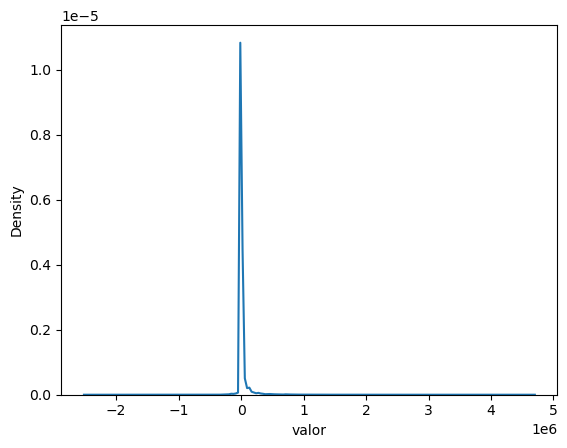

In [16]:
# Gráfico de densidade
sns.kdeplot(df_receitas_copy['valor'])

### Análise da correlação entre as variáveis utilizando a matriz de correlação e gráficos de dispersão

<Axes: >

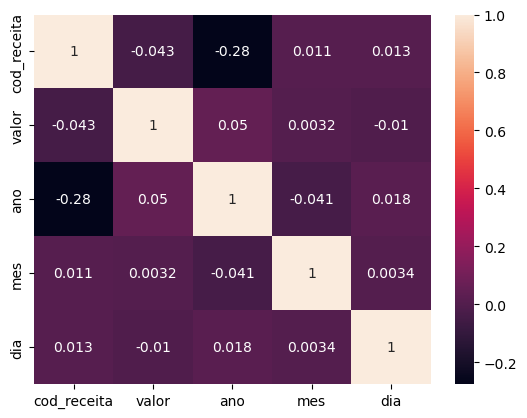

In [17]:
# Matriz de correlação
corr_matrix = df_receitas_copy.corr()
sns.heatmap(corr_matrix, annot=True)

<Axes: xlabel='ano', ylabel='valor'>

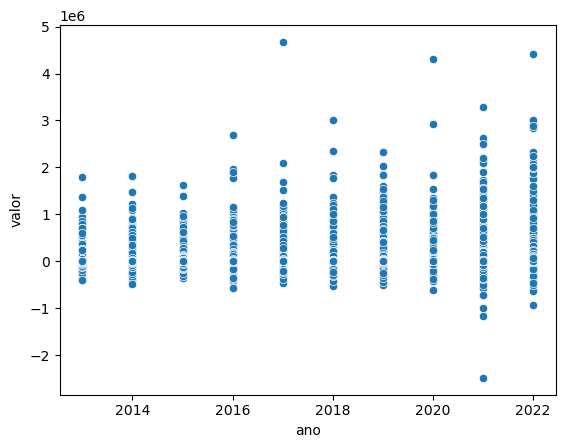

In [18]:
# Gráfico de dispersão
sns.scatterplot(x='ano', y='valor', data=df_receitas_copy)

<Axes: xlabel='mes', ylabel='valor'>

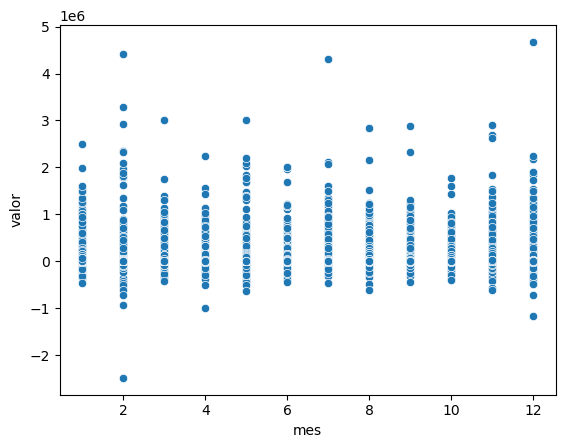

In [19]:
# Gráfico de dispersão
sns.scatterplot(x='mes', y='valor', data=df_receitas_copy)

<Axes: xlabel='dia', ylabel='valor'>

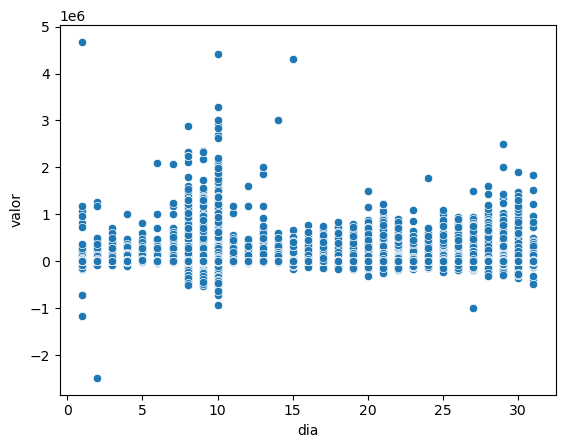

In [20]:
# Gráfico de dispersão
sns.scatterplot(x='dia', y='valor', data=df_receitas_copy)

<Axes: xlabel='cod_receita', ylabel='valor'>

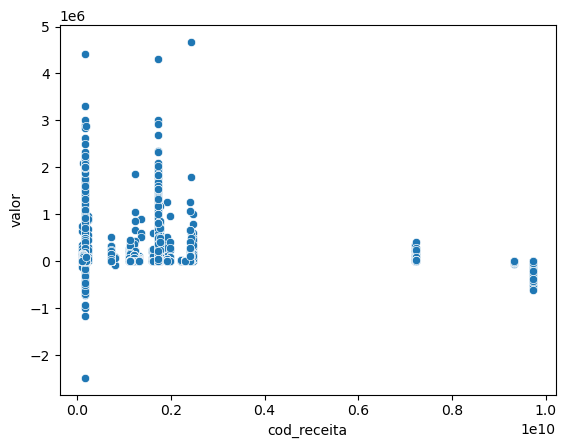

In [21]:
# Gráfico de dispersão
sns.scatterplot(x='cod_receita', y='valor', data=df_receitas_copy)

<Axes: xlabel='contribuinte_receita', ylabel='valor'>

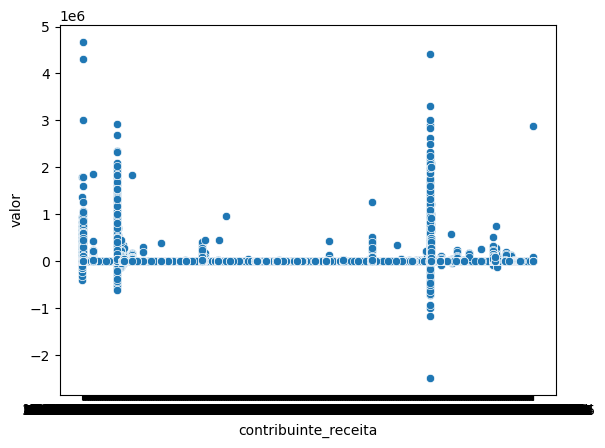

In [22]:
# Gráfico de dispersão
sns.scatterplot(x='contribuinte_receita', y='valor', data=df_receitas_copy)

### Verificação da presença de outliers:

<Axes: xlabel='valor'>

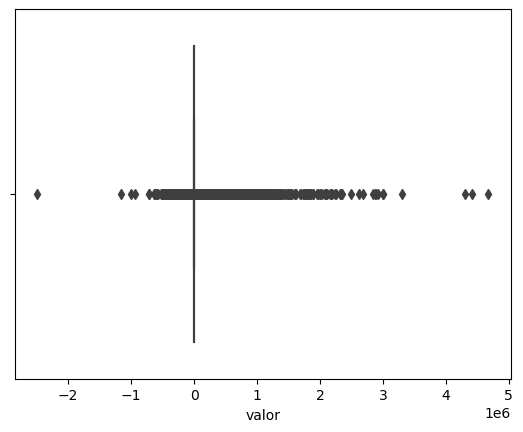

In [23]:
# Boxplot
sns.boxplot(x=df_receitas_copy['valor'])

<Axes: xlabel='ano', ylabel='valor'>

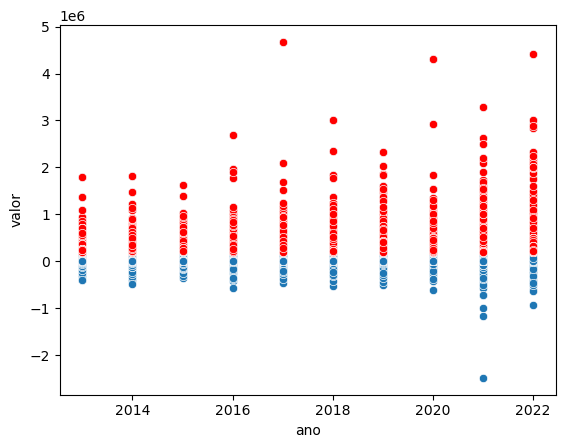

In [24]:
# Cálculo do threshold
threshold = np.mean(df_receitas_copy['valor']) + 2*np.std(df_receitas_copy['valor'])

# Gráfico de dispersão com pontos identificando os outliers
sns.scatterplot(x='ano', y='valor', data=df_receitas_copy)
sns.scatterplot(x=df_receitas_copy[df_receitas_copy['valor'] > threshold]['ano'], y=df_receitas_copy[df_receitas_copy['valor'] > threshold]['valor'], color='red')

### Verificação da distribuição das variáveis categóricas:

In [25]:
# Tabela de frequência
df_receitas_copy.groupby('contribuinte_receita').size()

contribuinte_receita
003049da08d3f8    1
0092a3488bcfb5    1
00afe72ed3d02e    4
0105fc482311ad    1
01489a24fb8fcf    2
                 ..
ff2cbd4aeb9c19    5
ff5b51a789b79b    6
ff6395491463ed    6
ffaca42fd6e45b    1
ffcea22fc174fc    3
Length: 1566, dtype: int64

<Axes: xlabel='contribuinte_receita', ylabel='count'>

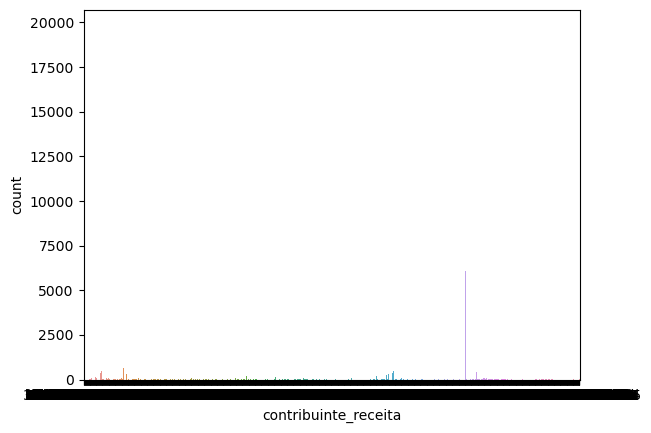

In [26]:
# Gráfico de barras
sns.countplot(x='contribuinte_receita', data=df_receitas_copy)

<Axes: xlabel='cod_receita', ylabel='count'>

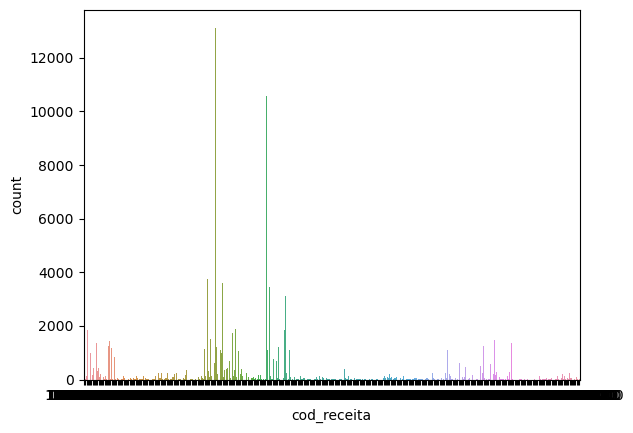

In [27]:
# Gráfico de barras
sns.countplot(x='cod_receita', data=df_receitas_copy)

### Análise da relação entre a variável alvo e as variáveis categóricas:

<Axes: xlabel='cod_receita', ylabel='valor'>

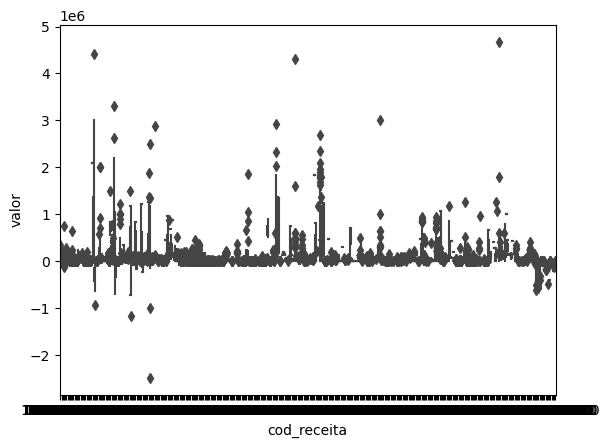

In [28]:
# Boxplot
sns.boxplot(x='cod_receita', y='valor', data=df_receitas_copy)

<Axes: xlabel='contribuinte_receita', ylabel='valor'>

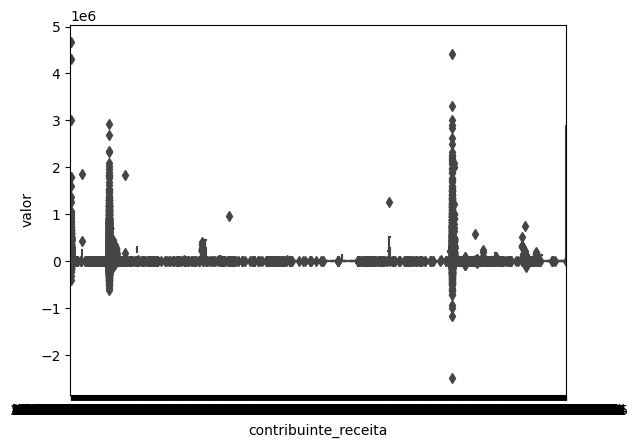

In [29]:
# Boxplot
sns.boxplot(x='contribuinte_receita', y='valor', data=df_receitas_copy)

<Axes: xlabel='ano', ylabel='valor'>

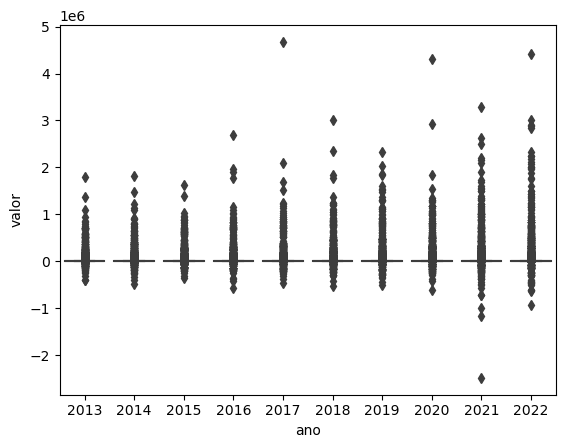

In [30]:
# Boxplot
sns.boxplot(x='ano', y='valor', data=df_receitas_copy)

<Axes: xlabel='mes', ylabel='valor'>

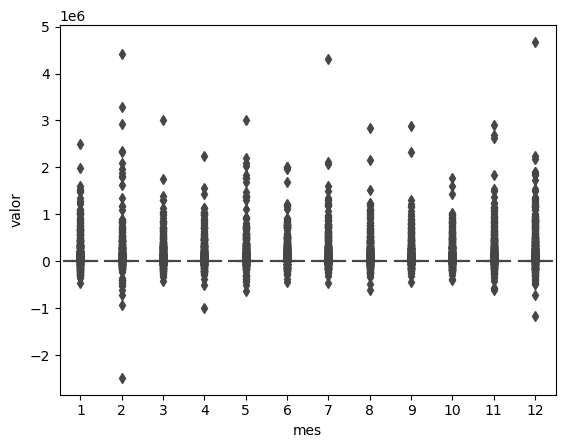

In [31]:
# Boxplot
sns.boxplot(x='mes', y='valor', data=df_receitas_copy)

<Axes: xlabel='dia', ylabel='valor'>

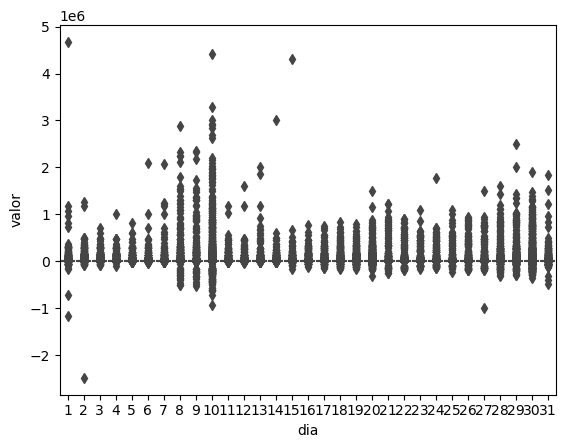

In [32]:
# Boxplot
sns.boxplot(x='dia', y='valor', data=df_receitas_copy)

In [33]:
# Teste de ANOVA
# Remover linhas com valores ausentes
df_receitas_clean = df_receitas_copy.dropna()

# Realizar o teste ANOVA para as variáveis categóricas

groups = []
for code in df_receitas_clean['cod_receita'].unique():
    group = df_receitas_clean[df_receitas_clean['cod_receita'] == code]['valor']
    groups.append(group)
    
fvalue, pvalue = stats.f_oneway(*groups)
print('F-value:', fvalue)
print('p-value:', pvalue)

F-value: 186.53962131637732
p-value: 0.0


In [34]:
# Realizar o teste ANOVA para as variáveis categóricas
groups = []
for code in df_receitas_clean['contribuinte_receita'].unique():
    group = df_receitas_clean[df_receitas_clean['contribuinte_receita'] == code]['valor']
    groups.append(group)
    
fvalue, pvalue = stats.f_oneway(*groups)
print('F-value:', fvalue)
print('p-value:', pvalue)

F-value: 2.183828439679764
p-value: 8.923906789228629e-136


In [35]:
# Realizar o teste ANOVA para as variáveis categóricas
groups = []
for code in df_receitas_clean['ano'].unique():
    group = df_receitas_clean[df_receitas_clean['ano'] == code]['valor']
    groups.append(group)
    
fvalue, pvalue = stats.f_oneway(*groups)
print('F-value:', fvalue)
print('p-value:', pvalue)

F-value: 40.01728812418291
p-value: 5.847470420979971e-72


In [36]:
# Realizar o teste ANOVA para as variáveis categóricas
groups = []
for code in df_receitas_clean['mes'].unique():
    group = df_receitas_clean[df_receitas_clean['mes'] == code]['valor']
    groups.append(group)
    
fvalue, pvalue = stats.f_oneway(*groups)
print('F-value:', fvalue)
print('p-value:', pvalue)

F-value: 1.3512821624376834
p-value: 0.18882400683394612


In [37]:
# Realizar o teste ANOVA para as variáveis categóricas
groups = []
for code in df_receitas_clean['dia'].unique():
    group = df_receitas_clean[df_receitas_clean['dia'] == code]['valor']
    groups.append(group)
    
fvalue, pvalue = stats.f_oneway(*groups)
print('F-value:', fvalue)
print('p-value:', pvalue)

F-value: 16.01745106718474
p-value: 1.9738070655107013e-82


### Análise da distribuição dos valores da variável alvo em relação ao tempo:

In [38]:
df_receitas_copy.head(1)

cod_receita  data_fato contribuinte_receita      valor   ano  mes  dia  \
0   1722010101 2013-01-03       886cd0eabf5a18  185560.68  2013    1    3   

   mes_ano  
0  01-2013

<Axes: xlabel='dia', ylabel='Count'>

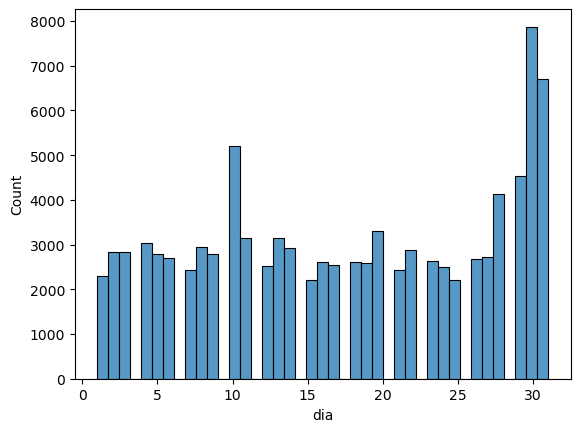

In [39]:
# Histograma por dia, mês e ano
sns.histplot(df_receitas_copy['valor'], x=df_receitas_copy['dia'])

<Axes: xlabel='mes', ylabel='Count'>

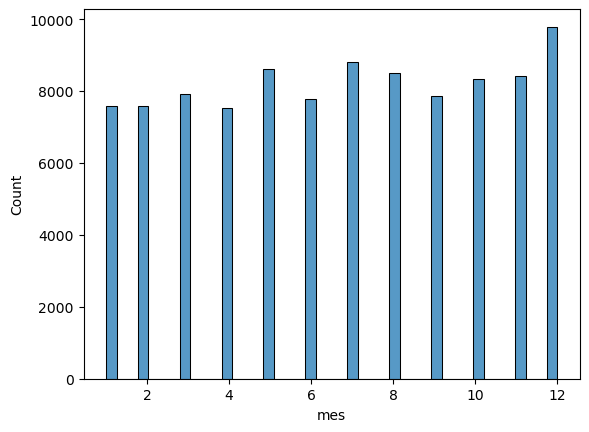

In [40]:
sns.histplot(df_receitas_copy['valor'], x=df_receitas_copy['mes'])

<Axes: xlabel='ano', ylabel='Count'>

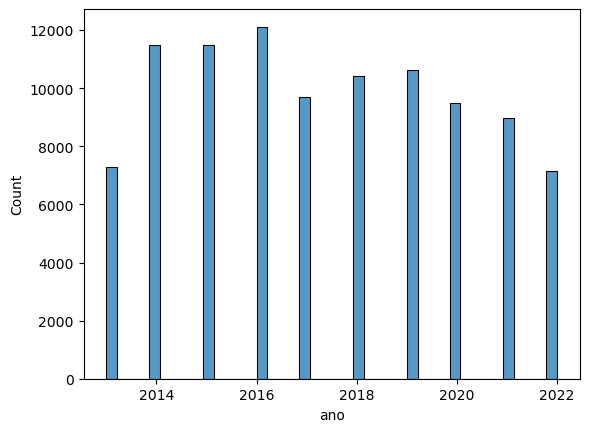

In [41]:
sns.histplot(df_receitas_copy['valor'], x=df_receitas_copy['ano'])

### Agrupando a receita por ano e somando os valores

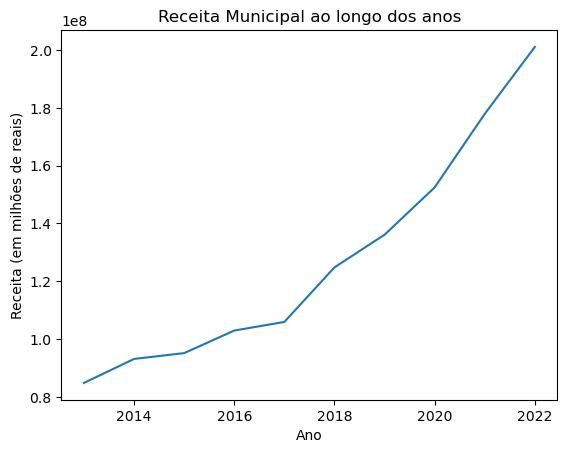

In [42]:
receita_por_ano = df_receitas_copy.groupby('ano')['valor'].sum()

# Plotando o gráfico de linha
plt.plot(receita_por_ano.index, receita_por_ano.values)
plt.title('Receita Municipal ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Receita (em milhões de reais)')
plt.show()

### Gráfico de linha com a média mensal da receita


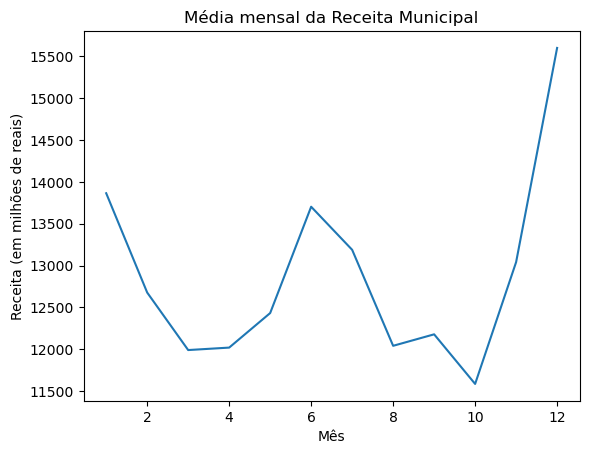

In [43]:
receita_por_mes = df_receitas_copy.groupby('mes')['valor'].mean()

# Plotando o gráfico de linha
plt.plot(receita_por_mes.index, receita_por_mes.values)
plt.title('Média mensal da Receita Municipal')
plt.xlabel('Mês')
plt.ylabel('Receita (em milhões de reais)')
plt.show()

### Gráfico de linha com a receita diária

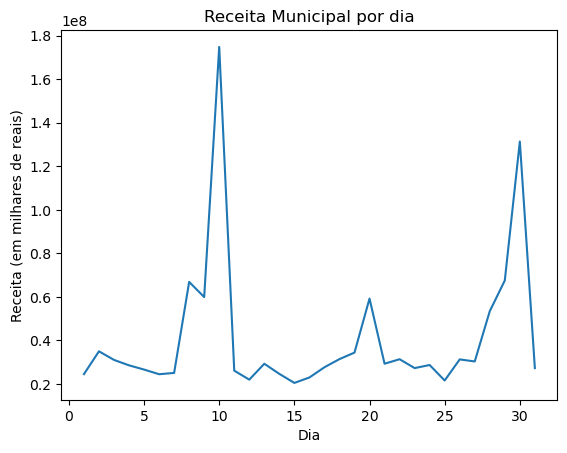

In [44]:
receita_por_dia = df_receitas_copy.groupby('dia')['valor'].sum()

# Plotando o gráfico de linha
plt.plot(receita_por_dia.index, receita_por_dia.values)
plt.title('Receita Municipal por dia')
plt.xlabel('Dia')
plt.ylabel('Receita (em milhares de reais)')
plt.show()

## Times Series

#### Dados brutos

In [45]:
df_receita_mes_ano = df_receitas_copy[['valor','mes_ano']].copy()
df_receita_mes_ano.head()

valor  mes_ano
0  185560.68  01-2013
1    8081.80  01-2013
2    4231.39  01-2013
3   10536.53  01-2013
4  103118.27  01-2013

In [46]:
df_receita_mes_ano['mes_ano'] = pd.to_datetime(df_receita_mes_ano['mes_ano'], format='%m-%Y')
df_receita_mes_ano.head()

valor    mes_ano
0  185560.68 2013-01-01
1    8081.80 2013-01-01
2    4231.39 2013-01-01
3   10536.53 2013-01-01
4  103118.27 2013-01-01

In [47]:
df_grouped = df_receita_mes_ano.groupby(pd.Grouper(key='mes_ano')).sum()
df_grouped.reset_index(inplace=True)
df_grouped.rename(columns={'valor_mensal': 'valor_agrupado'}, inplace=True)

df_merged = pd.merge(df_receita_mes_ano, df_grouped, on='mes_ano')
df_merged.drop(columns={'valor_x'}, inplace=True)
df_merged.drop_duplicates(subset='mes_ano', inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged.rename(columns={'valor_y':'valor_mensal'}, inplace=True)
df_receita_mes_ano = df_merged.copy()

In [48]:
df_receita_mes_ano

mes_ano  valor_mensal
0   2013-01-01    5855243.48
1   2013-02-01    6977997.85
2   2013-03-01    6003101.60
3   2013-04-01    6033704.83
4   2013-05-01    6558550.11
..         ...           ...
115 2022-05-01   17872926.83
116 2022-04-01   13217971.69
117 2022-03-01   15360587.35
118 2022-02-01   14791870.57
119 2022-01-01   17381431.99

[120 rows x 2 columns]

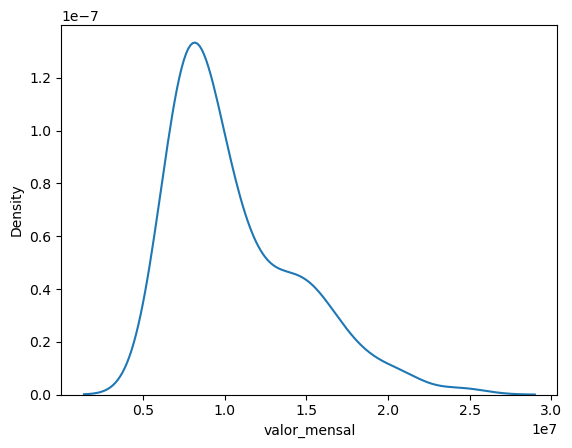

In [49]:
sns.kdeplot(df_receita_mes_ano['valor_mensal'])
plt.show()

In [50]:
df_receita_mes_ano_normal = df_receita_mes_ano.copy()

In [51]:
df_receita_mes_ano_normal['diferenca_receita_mensal'] = df_receita_mes_ano_normal['valor_mensal'].diff()
df_receita_mes_ano_normal

mes_ano  valor_mensal  diferenca_receita_mensal
0   2013-01-01    5855243.48                       NaN
1   2013-02-01    6977997.85                1122754.37
2   2013-03-01    6003101.60                -974896.25
3   2013-04-01    6033704.83                  30603.23
4   2013-05-01    6558550.11                 524845.28
..         ...           ...                       ...
115 2022-05-01   17872926.83               -6654006.75
116 2022-04-01   13217971.69               -4654955.14
117 2022-03-01   15360587.35                2142615.66
118 2022-02-01   14791870.57                -568716.78
119 2022-01-01   17381431.99                2589561.42

[120 rows x 3 columns]

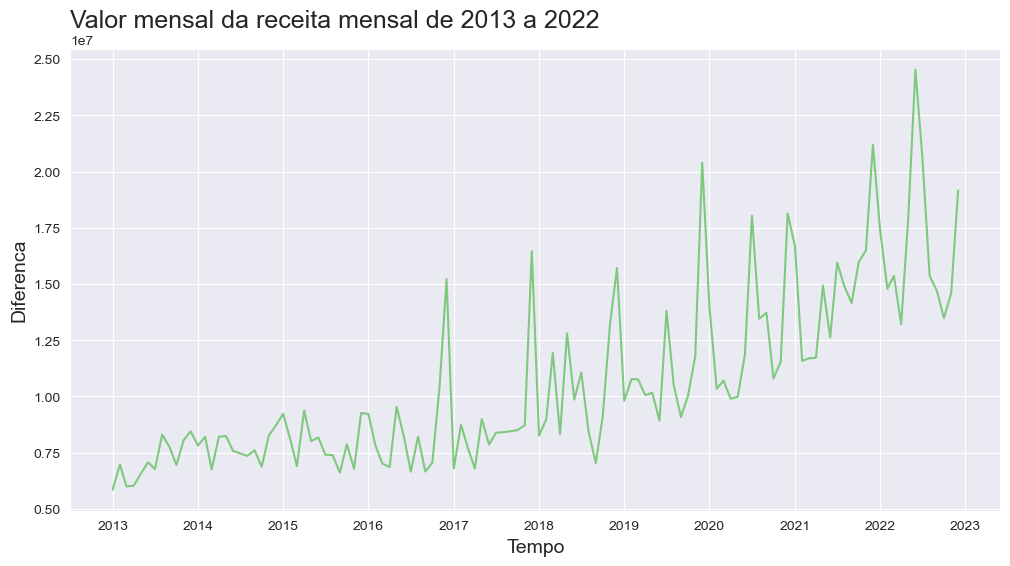

In [52]:
plotar('Valor mensal da receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','valor_mensal',df_receita_mes_ano_normal)

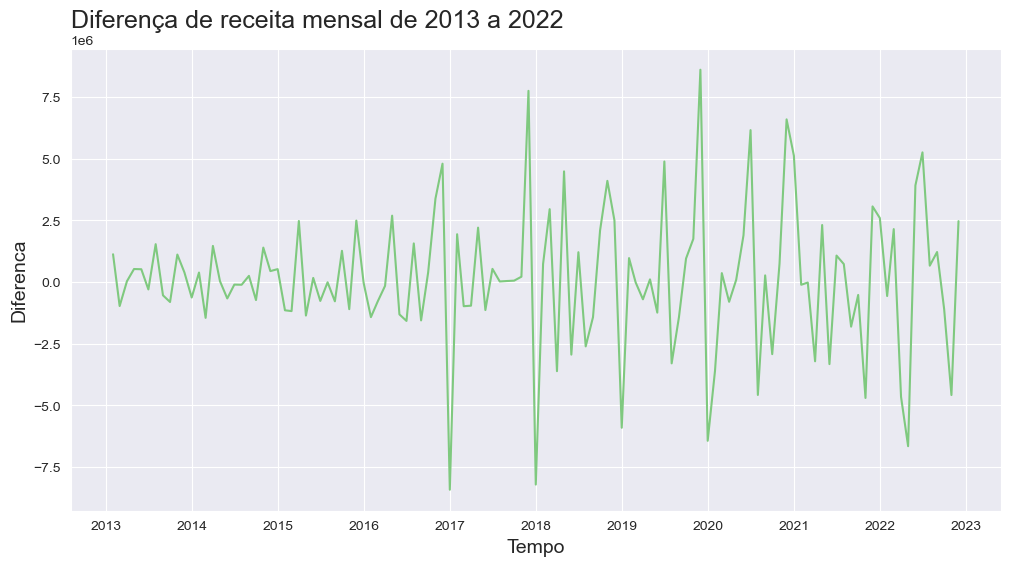

In [53]:
plotar('Diferença de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','diferenca_receita_mensal',df_receita_mes_ano_normal)

In [54]:
df_receita_mes_ano_normal['aceleracao_diferenca_receita_mensal'] = df_receita_mes_ano_normal['diferenca_receita_mensal'].diff()
df_receita_mes_ano_normal

mes_ano  valor_mensal  diferenca_receita_mensal  \
0   2013-01-01    5855243.48                       NaN   
1   2013-02-01    6977997.85                1122754.37   
2   2013-03-01    6003101.60                -974896.25   
3   2013-04-01    6033704.83                  30603.23   
4   2013-05-01    6558550.11                 524845.28   
..         ...           ...                       ...   
115 2022-05-01   17872926.83               -6654006.75   
116 2022-04-01   13217971.69               -4654955.14   
117 2022-03-01   15360587.35                2142615.66   
118 2022-02-01   14791870.57                -568716.78   
119 2022-01-01   17381431.99                2589561.42   

     aceleracao_diferenca_receita_mensal  
0                                    NaN  
1                                    NaN  
2                            -2097650.62  
3                             1005499.48  
4                              494242.05  
..                                   ...  
115                         -10567709.39  
116                           1999051.61  
117                           6797570.80  
118                          -2711332.44  
119                           3158278.20  

[120 rows x 4 columns]

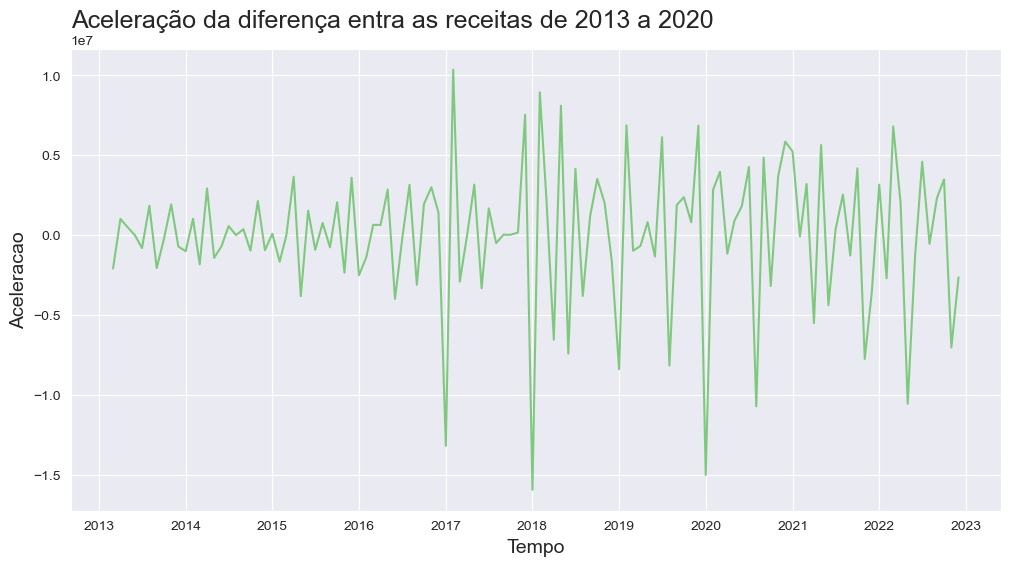

In [55]:
plotar('Aceleração da diferença entra as receitas de 2013 a 2020', 'Tempo','Aceleracao','mes_ano','aceleracao_diferenca_receita_mensal', df_receita_mes_ano_normal)

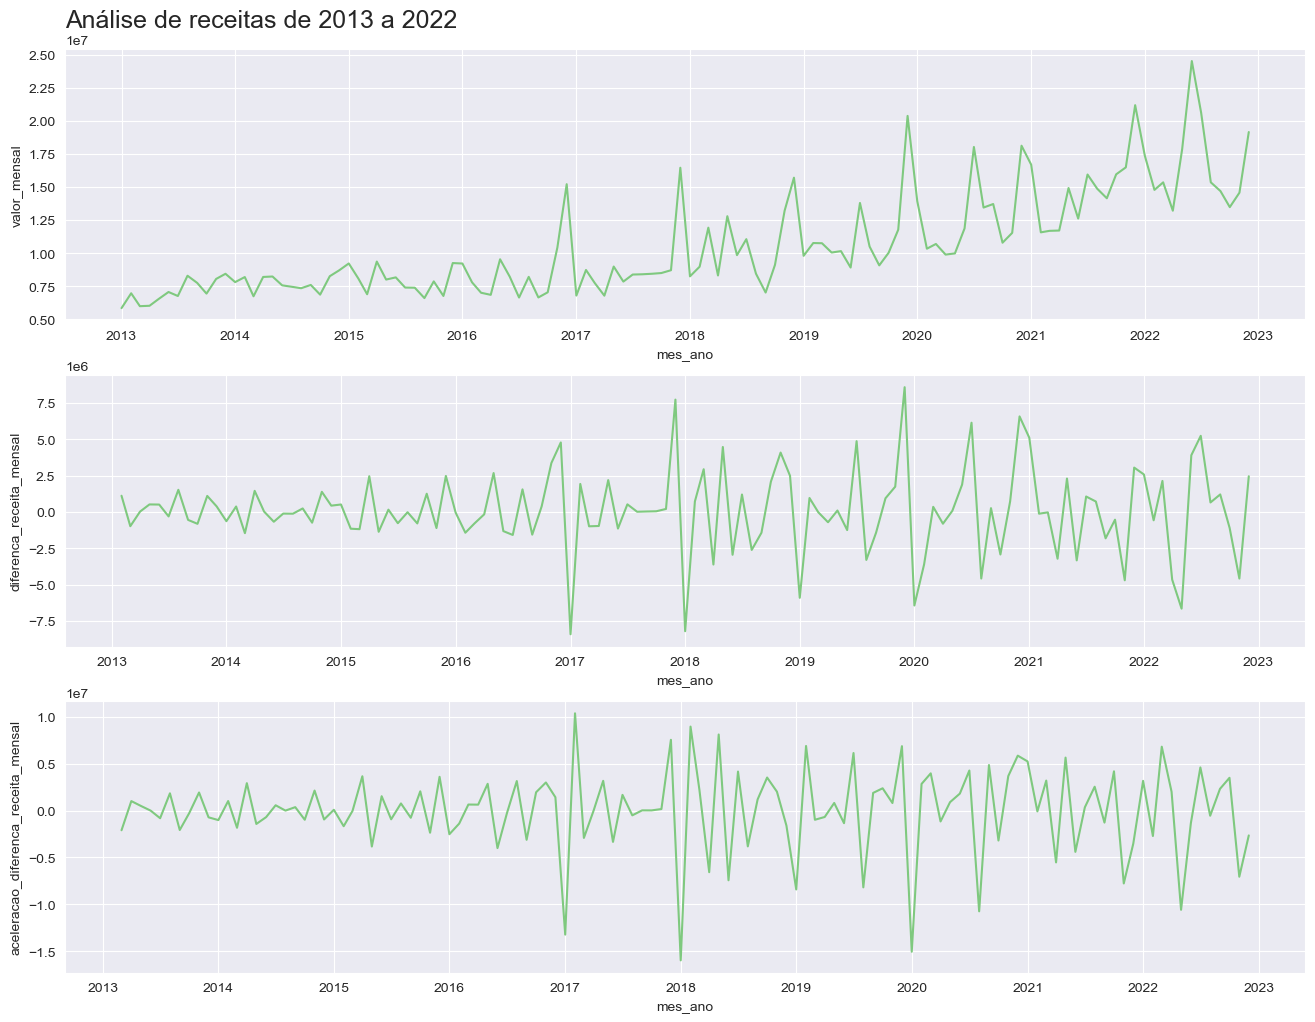

In [56]:
plot_comparacao('mes_ano','valor_mensal','diferenca_receita_mensal','aceleracao_diferenca_receita_mensal', df_receita_mes_ano_normal,
                    'Análise de receitas de 2013 a 2022')

In [57]:
from pandas.plotting import autocorrelation_plot as atcp

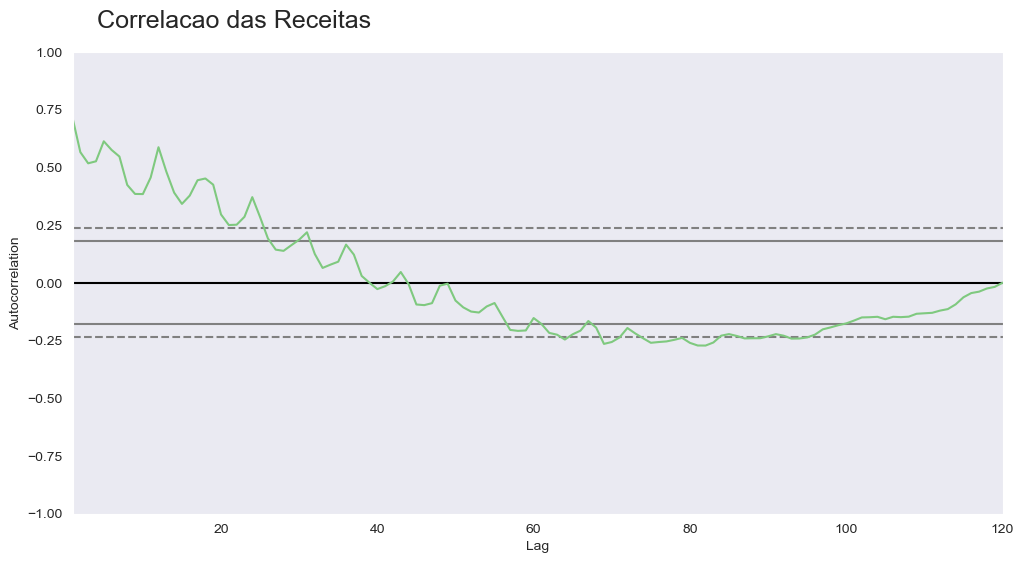

In [58]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao das Receitas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_normal['valor_mensal'])
ax=ax

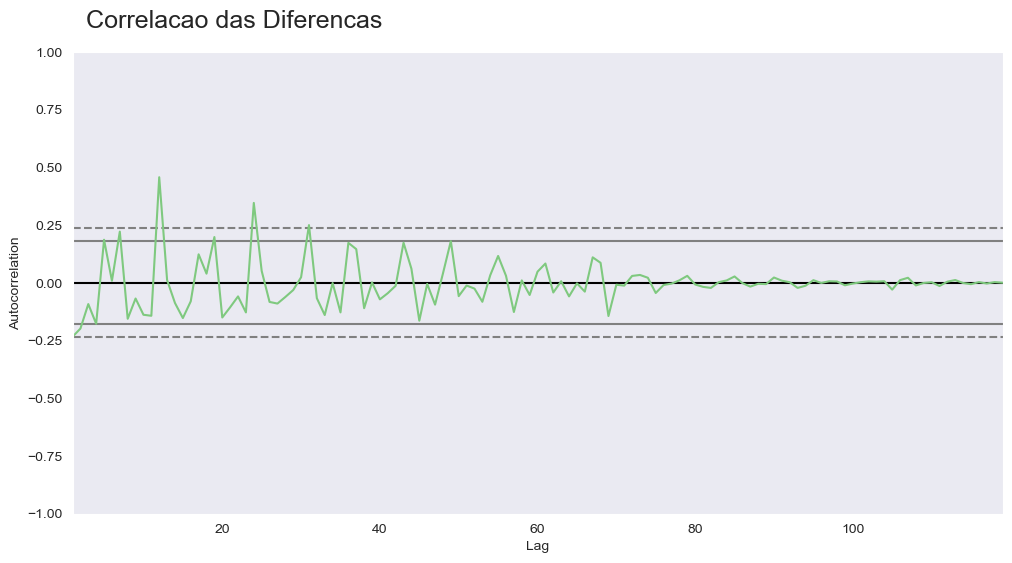

In [59]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao das Diferencas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_normal['diferenca_receita_mensal'][1:])
ax=ax

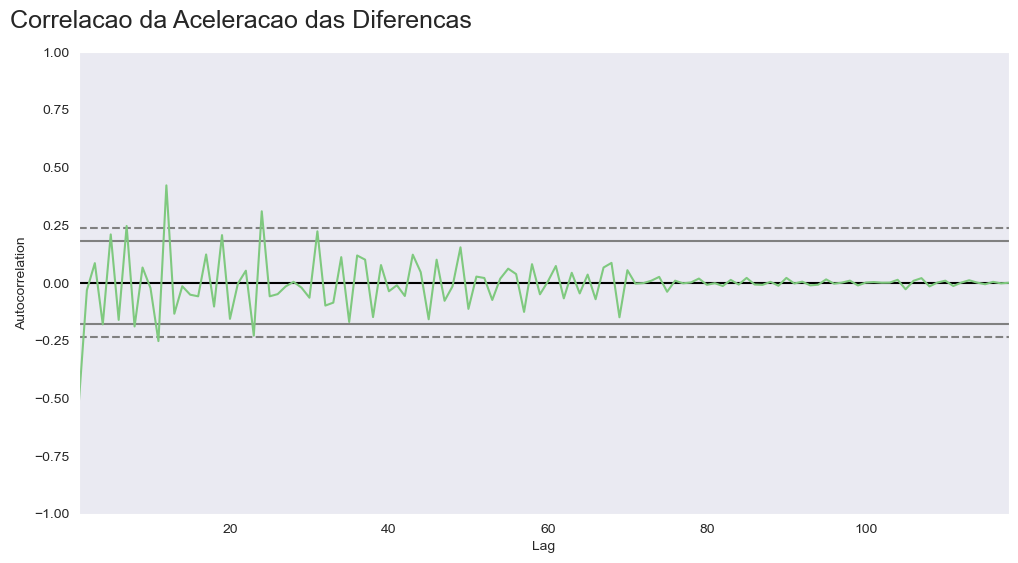

In [60]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao da Aceleracao das Diferencas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_normal['aceleracao_diferenca_receita_mensal'][2:])
ax=ax

#### Normalizando os dados usando func. logarítimica

In [61]:
df_receita_mes_ano_log = df_receita_mes_ano.copy()
df_receita_mes_ano_log['valor_mensal_log'] = df_receita_mes_ano_log['valor_mensal'].apply(np.log)
df_receita_mes_ano_log

mes_ano  valor_mensal  valor_mensal_log
0   2013-01-01    5855243.48         15.582848
1   2013-02-01    6977997.85         15.758273
2   2013-03-01    6003101.60         15.607787
3   2013-04-01    6033704.83         15.612872
4   2013-05-01    6558550.11         15.696280
..         ...           ...               ...
115 2022-05-01   17872926.83         16.698798
116 2022-04-01   13217971.69         16.397088
117 2022-03-01   15360587.35         16.547316
118 2022-02-01   14791870.57         16.509588
119 2022-01-01   17381431.99         16.670913

[120 rows x 3 columns]

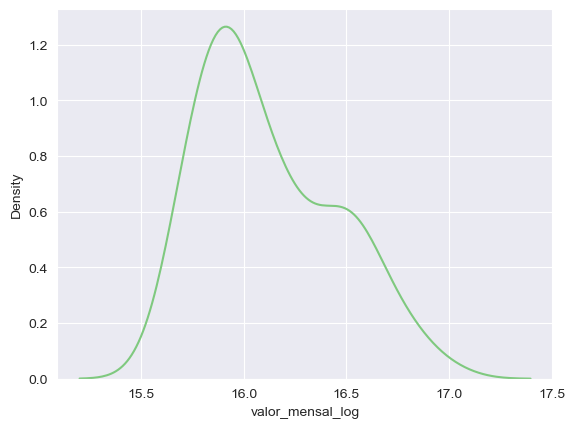

In [62]:
sns.kdeplot(df_receita_mes_ano_log['valor_mensal_log'])
plt.show()

In [63]:
df_receita_mes_ano_log['diferenca_receita_mensal_log'] = df_receita_mes_ano_log['valor_mensal_log'].diff()
df_receita_mes_ano_log['aceleracao_diferenca_receita_mensal_log'] = df_receita_mes_ano_log['diferenca_receita_mensal_log'].diff()
df_receita_mes_ano_log

mes_ano  valor_mensal  valor_mensal_log  diferenca_receita_mensal_log  \
0   2013-01-01    5855243.48         15.582848                           NaN   
1   2013-02-01    6977997.85         15.758273                      0.175424   
2   2013-03-01    6003101.60         15.607787                     -0.150486   
3   2013-04-01    6033704.83         15.612872                      0.005085   
4   2013-05-01    6558550.11         15.696280                      0.083408   
..         ...           ...               ...                           ...   
115 2022-05-01   17872926.83         16.698798                     -0.316485   
116 2022-04-01   13217971.69         16.397088                     -0.301710   
117 2022-03-01   15360587.35         16.547316                      0.150228   
118 2022-02-01   14791870.57         16.509588                     -0.037727   
119 2022-01-01   17381431.99         16.670913                      0.161325   

     aceleracao_diferenca_receita_mensal_log  
0                                        NaN  
1                                        NaN  
2                                  -0.325910  
3                                   0.155571  
4                                   0.078323  
..                                       ...  
115                                -0.490323  
116                                 0.014775  
117                                 0.451937  
118                                -0.187955  
119                                 0.199052  

[120 rows x 5 columns]

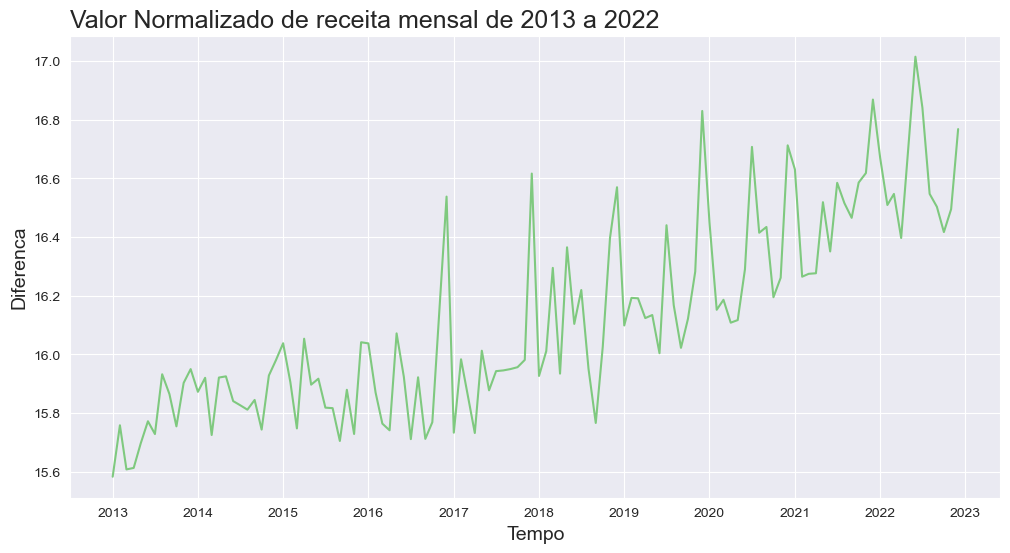

In [64]:
plotar('Valor Normalizado de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','valor_mensal_log',df_receita_mes_ano_log)

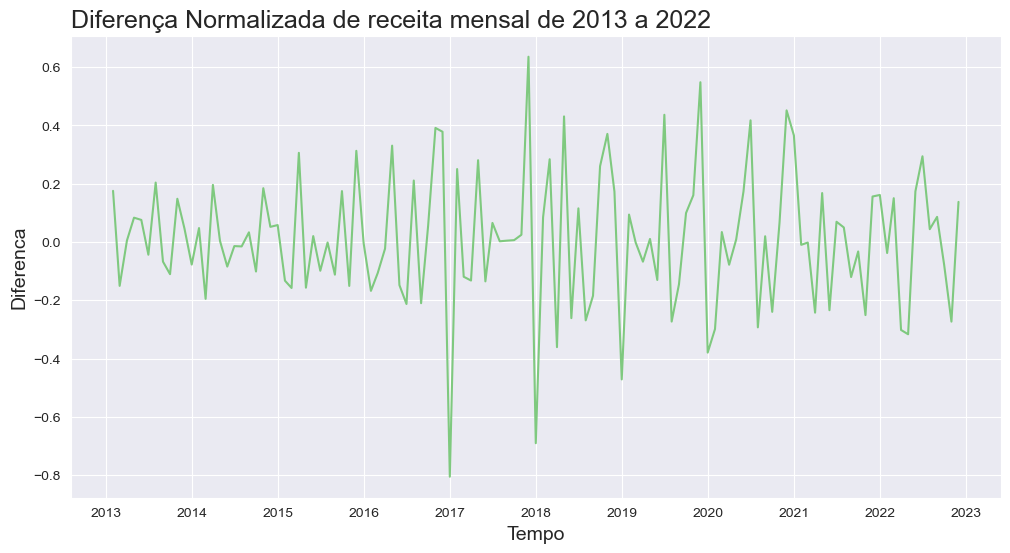

In [65]:
plotar('Diferença Normalizada de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','diferenca_receita_mensal_log',df_receita_mes_ano_log)

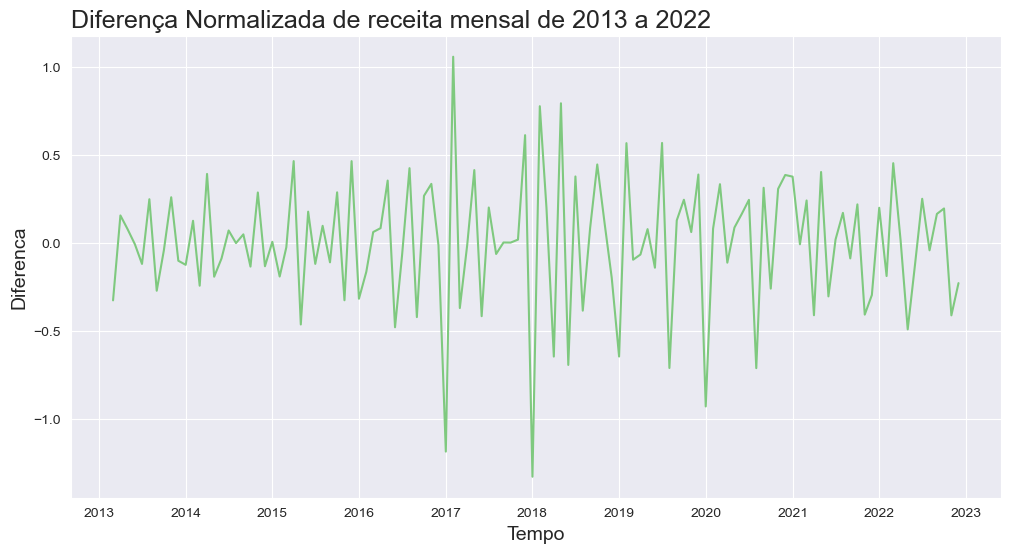

In [66]:
plotar('Diferença Normalizada de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','aceleracao_diferenca_receita_mensal_log',df_receita_mes_ano_log)

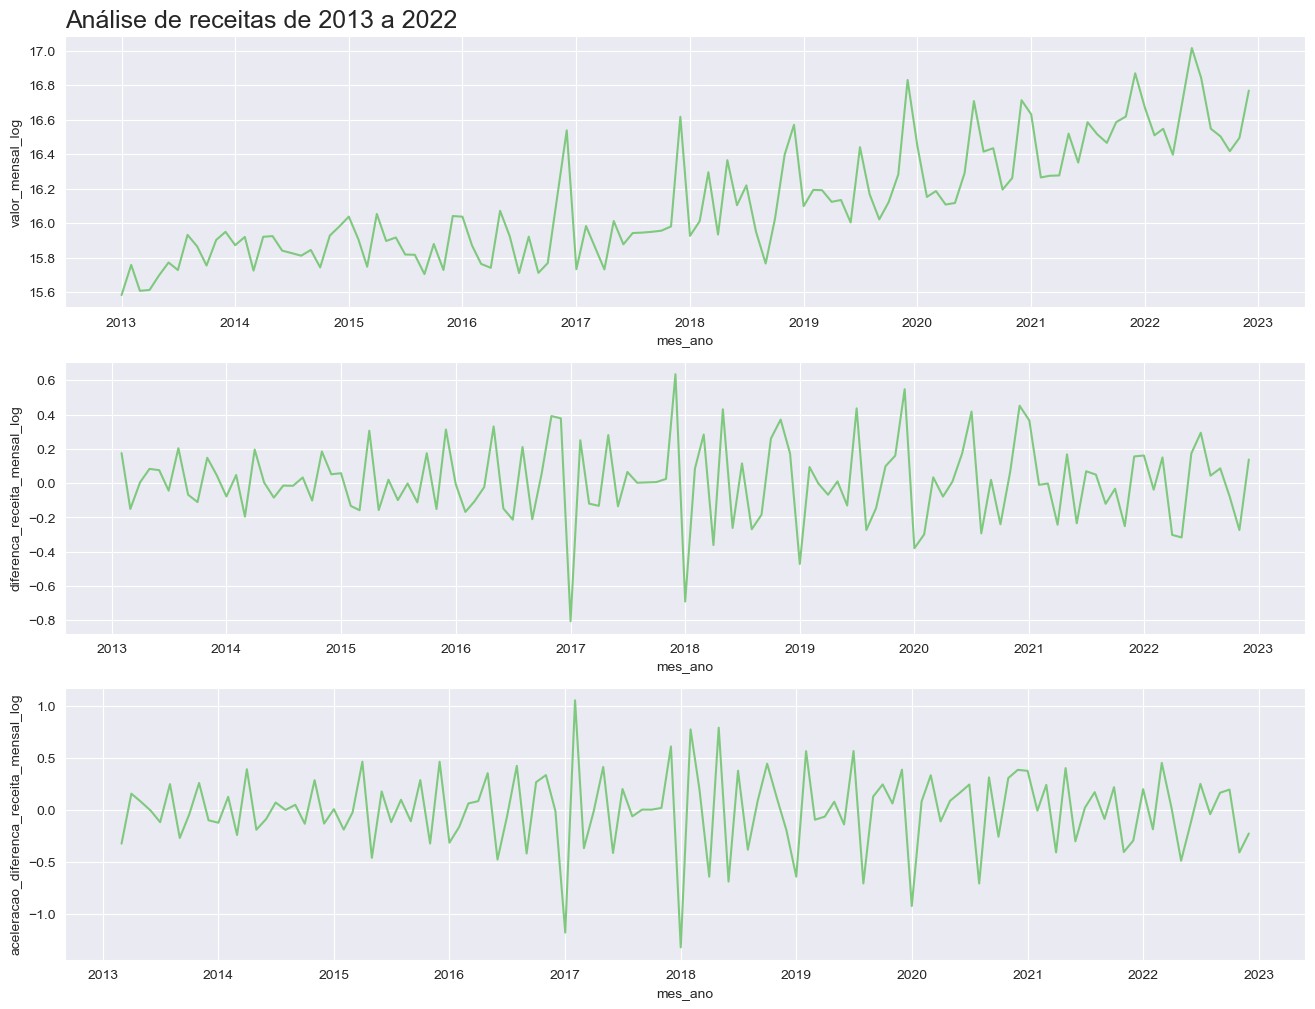

In [67]:
plot_comparacao('mes_ano','valor_mensal_log','diferenca_receita_mensal_log','aceleracao_diferenca_receita_mensal_log', df_receita_mes_ano_log,
                    'Análise de receitas de 2013 a 2022')

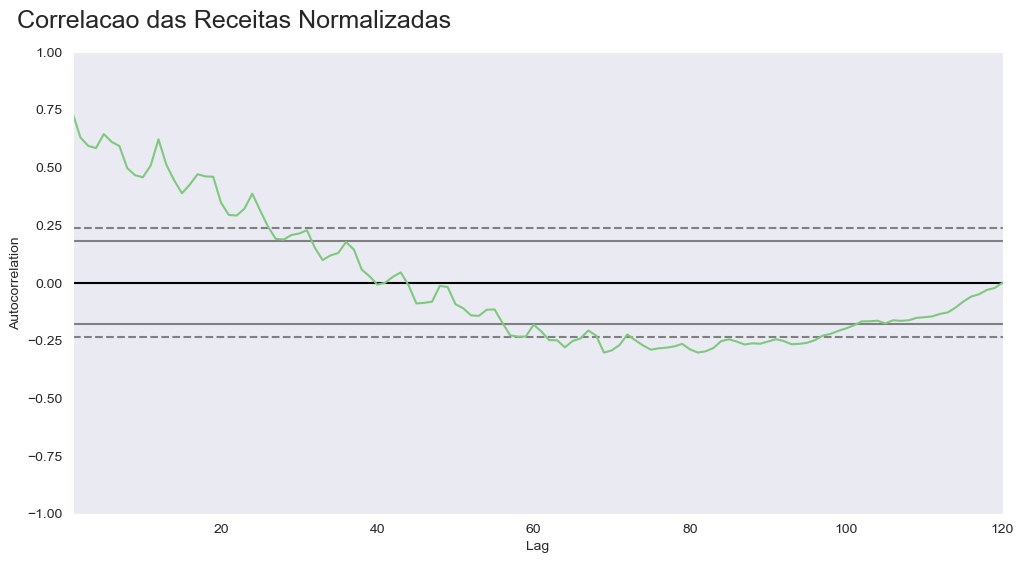

In [68]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao das Receitas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_log['valor_mensal_log'])
ax=ax

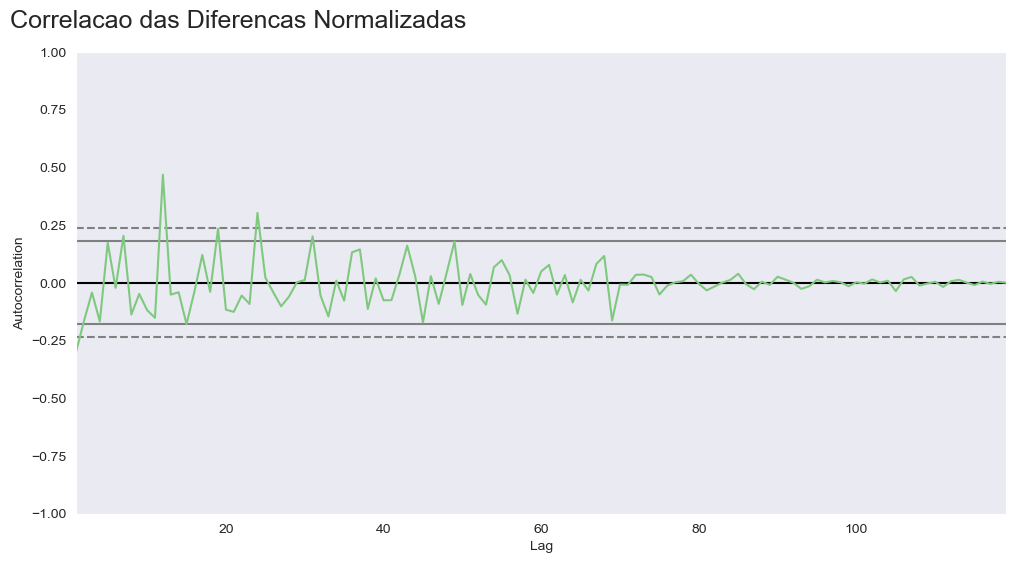

In [69]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao das Diferencas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_log['diferenca_receita_mensal_log'][1:])
ax=ax

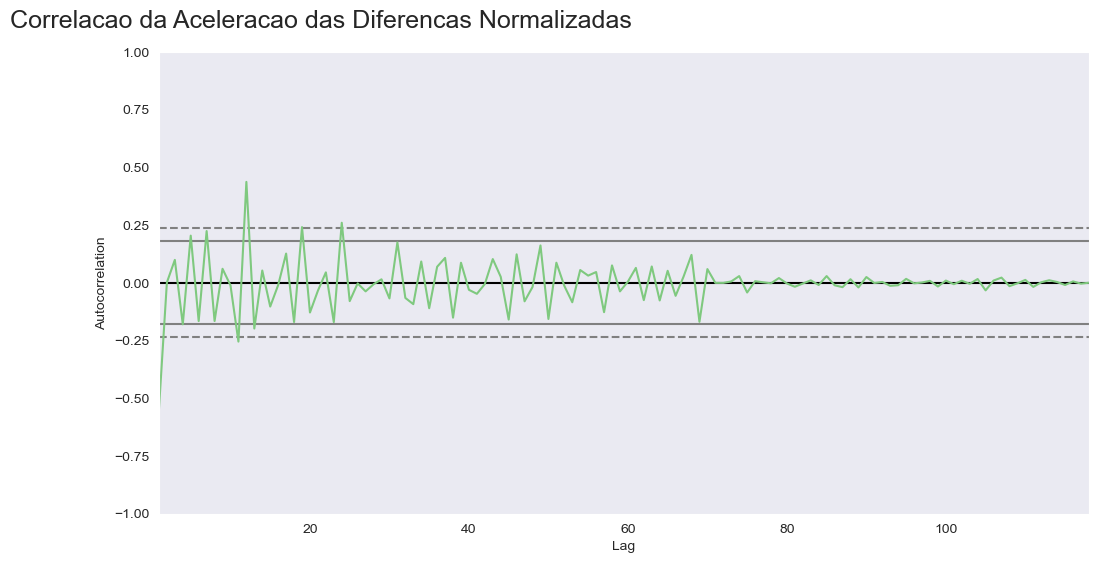

In [70]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao da Aceleracao das Diferencas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_log['aceleracao_diferenca_receita_mensal_log'][2:])
ax=ax

#### Normalização dos dados com Box-Cox

In [71]:
df_receita_mes_ano_boxcox = df_receita_mes_ano.copy()
df_receita_mes_ano_boxcox['valor_mensal_boxcox'], lambda_boxcox = stats.boxcox(df_receita_mes_ano_boxcox['valor_mensal'])
df_receita_mes_ano_boxcox

mes_ano  valor_mensal  valor_mensal_boxcox
0   2013-01-01    5855243.48             1.025579
1   2013-02-01    6977997.85             1.025579
2   2013-03-01    6003101.60             1.025579
3   2013-04-01    6033704.83             1.025579
4   2013-05-01    6558550.11             1.025579
..         ...           ...                  ...
115 2022-05-01   17872926.83             1.025579
116 2022-04-01   13217971.69             1.025579
117 2022-03-01   15360587.35             1.025579
118 2022-02-01   14791870.57             1.025579
119 2022-01-01   17381431.99             1.025579

[120 rows x 3 columns]

In [72]:
# verificando a constante lambda calculada
print('Lambda da transformação Box-Cox:', lambda_boxcox)

Lambda da transformação Box-Cox: -0.9750591150313285


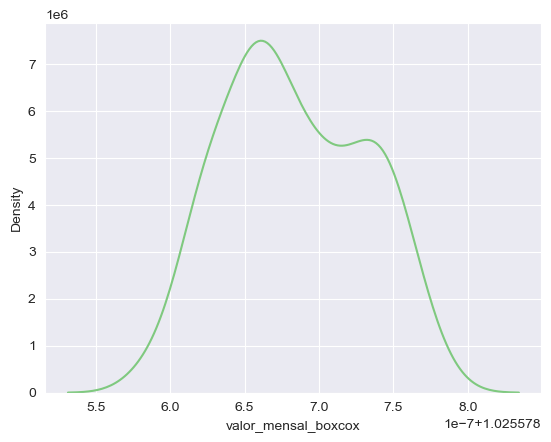

In [73]:
sns.kdeplot(df_receita_mes_ano_boxcox['valor_mensal_boxcox'])
plt.show()

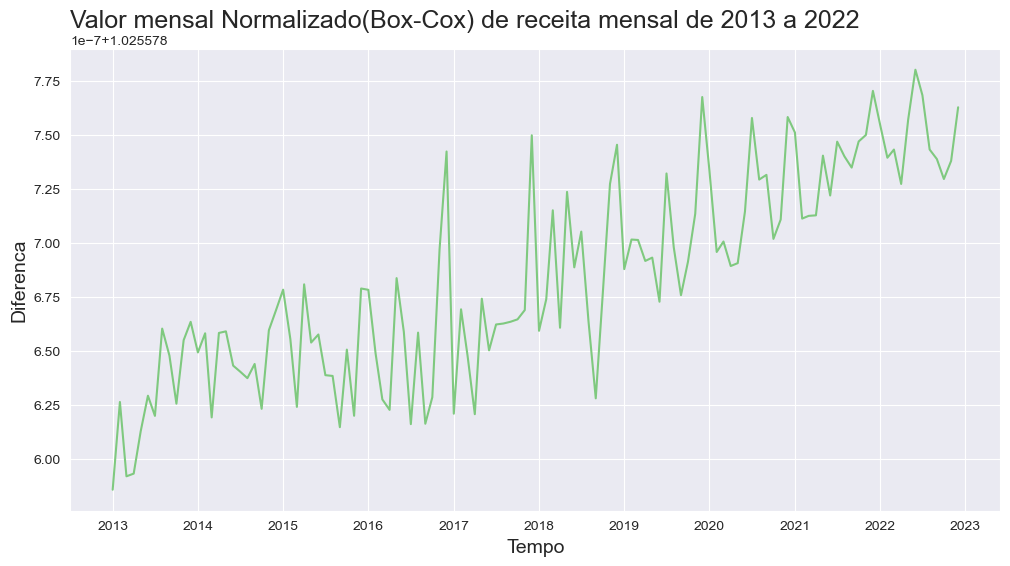

In [74]:
plotar('Valor mensal Normalizado(Box-Cox) de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','valor_mensal_boxcox',df_receita_mes_ano_boxcox)

In [75]:
df_receita_mes_ano_boxcox['diferenca_receita_mensal_boxcox'] = df_receita_mes_ano_boxcox['valor_mensal_boxcox'].diff()
df_receita_mes_ano_boxcox['aceleracao_diferenca_receita_mensal_boxcox'] = df_receita_mes_ano_boxcox['diferenca_receita_mensal_boxcox'].diff()
df_receita_mes_ano_boxcox

mes_ano  valor_mensal  valor_mensal_boxcox  \
0   2013-01-01    5855243.48             1.025579   
1   2013-02-01    6977997.85             1.025579   
2   2013-03-01    6003101.60             1.025579   
3   2013-04-01    6033704.83             1.025579   
4   2013-05-01    6558550.11             1.025579   
..         ...           ...                  ...   
115 2022-05-01   17872926.83             1.025579   
116 2022-04-01   13217971.69             1.025579   
117 2022-03-01   15360587.35             1.025579   
118 2022-02-01   14791870.57             1.025579   
119 2022-01-01   17381431.99             1.025579   

     diferenca_receita_mensal_boxcox  \
0                                NaN   
1                       4.061815e-08   
2                      -3.441164e-08   
3                       1.247078e-09   
4                       1.959741e-08   
..                               ...   
115                    -2.310710e-08   
116                    -2.976570e-08   
117                     1.591378e-08   
118                    -3.780027e-09   
119                     1.523333e-08   

     aceleracao_diferenca_receita_mensal_boxcox  
0                                           NaN  
1                                           NaN  
2                                 -7.502980e-08  
3                                  3.565872e-08  
4                                  1.835033e-08  
..                                          ...  
115                               -3.491395e-08  
116                               -6.658607e-09  
117                                4.567948e-08  
118                               -1.969380e-08  
119                                1.901336e-08  

[120 rows x 5 columns]

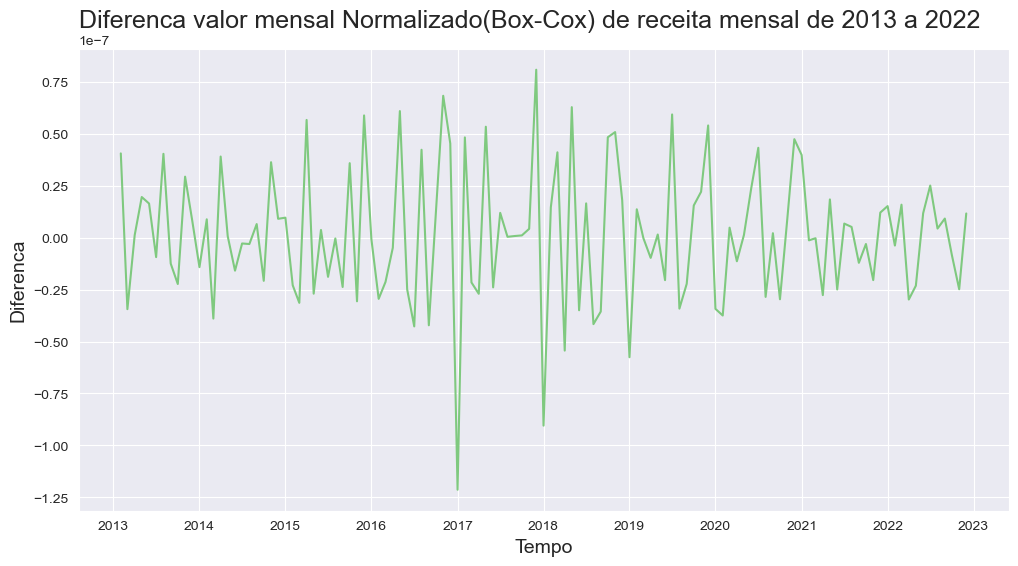

In [76]:
plotar('Diferenca valor mensal Normalizado(Box-Cox) de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','diferenca_receita_mensal_boxcox',df_receita_mes_ano_boxcox)

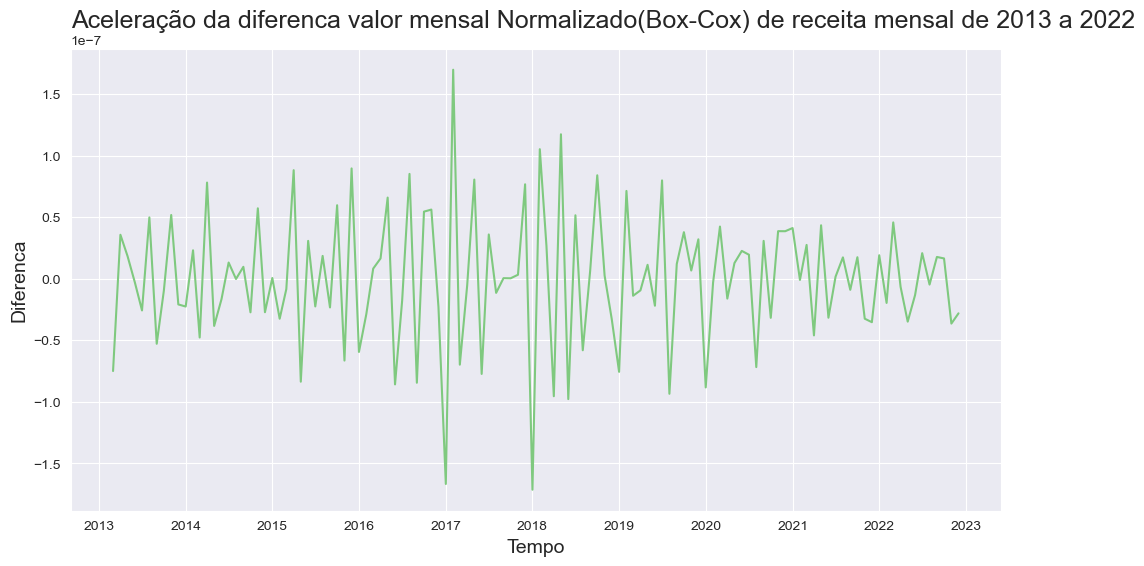

In [77]:
plotar('Aceleração da diferenca valor mensal Normalizado(Box-Cox) de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','aceleracao_diferenca_receita_mensal_boxcox',df_receita_mes_ano_boxcox)


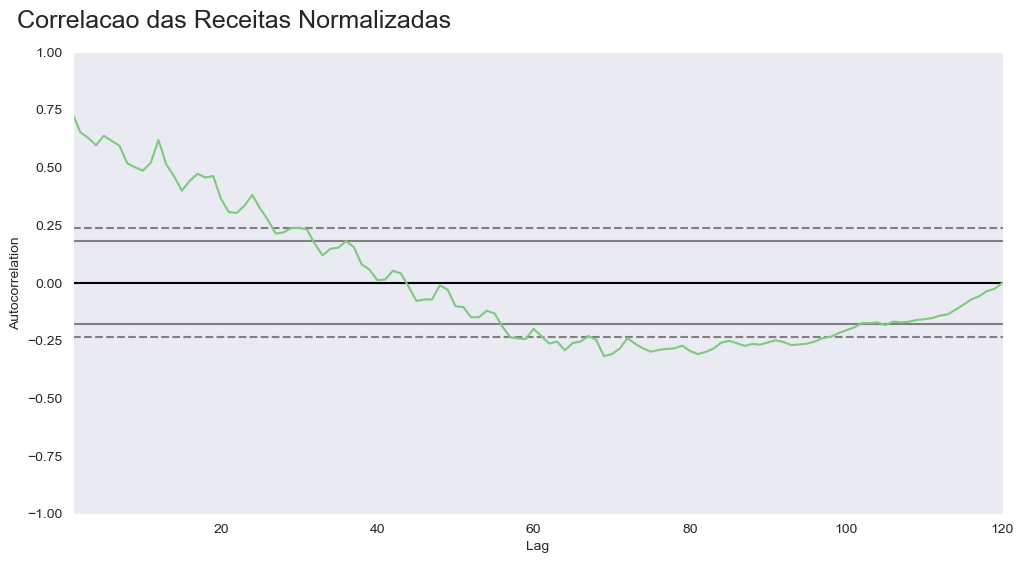

In [78]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao das Receitas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_boxcox['valor_mensal_boxcox'])
ax=ax

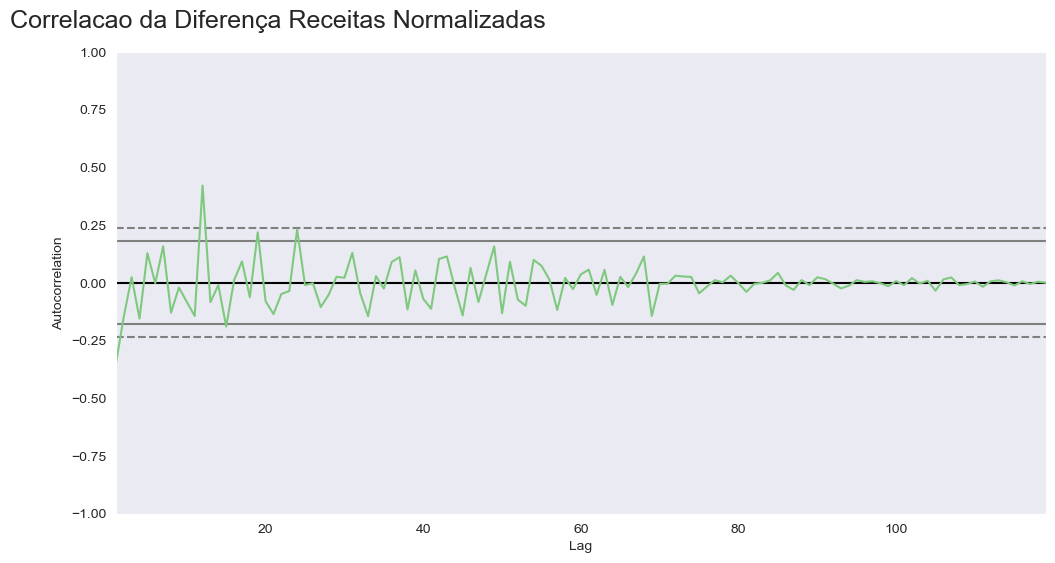

In [79]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao da Diferença Receitas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_boxcox['diferenca_receita_mensal_boxcox'][1:])
ax=ax

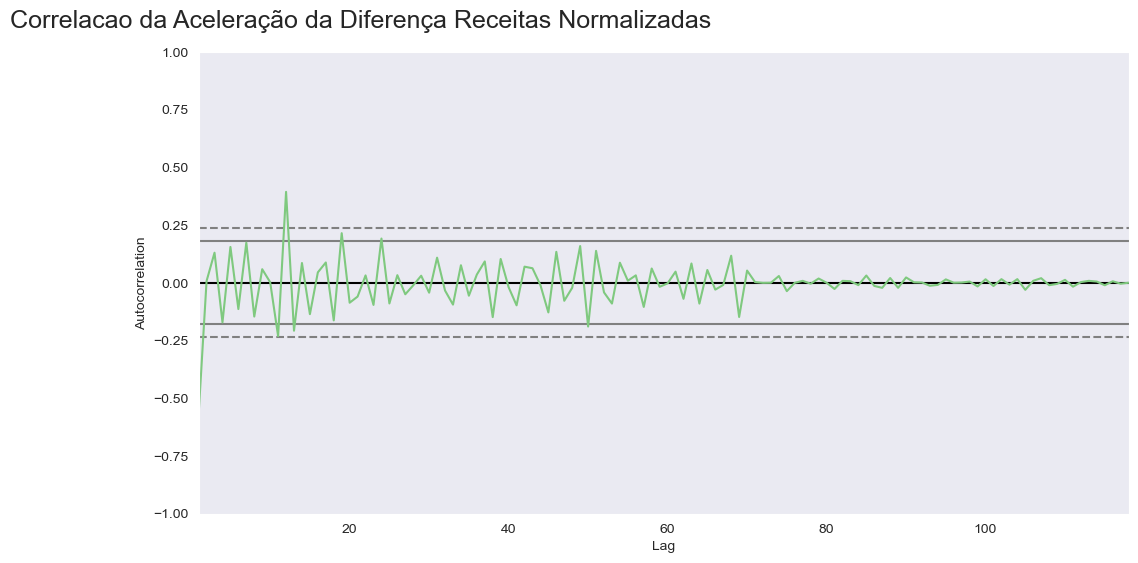

In [80]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao da Aceleração da Diferença Receitas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_boxcox['aceleracao_diferenca_receita_mensal_boxcox'][2:])
ax=ax

### Normalização por Z-Scoring(padronização)

In [81]:
from sklearn.preprocessing import StandardScaler

In [82]:
# Cria uma cópia do dataframe para normalização
df_receita_mes_ano_normz = df_receita_mes_ano.copy()

# Seleciona apenas a coluna 'valor_mensal' para normalização
valores = df_receita_mes_ano_normz['valor_mensal'].values.reshape(-1, 1)

# Normalização por padronização
scaler = StandardScaler()
valores_norm = scaler.fit_transform(valores)

# Salva os valores normalizados no dataframe
df_receita_mes_ano_normz['valor_mensal_normz'] = valores_norm

df_receita_mes_ano_normz

mes_ano  valor_mensal  valor_mensal_normz
0   2013-01-01    5855243.48           -1.235152
1   2013-02-01    6977997.85           -0.943995
2   2013-03-01    6003101.60           -1.196809
3   2013-04-01    6033704.83           -1.188873
4   2013-05-01    6558550.11           -1.052768
..         ...           ...                 ...
115 2022-05-01   17872926.83            1.881321
116 2022-04-01   13217971.69            0.674179
117 2022-03-01   15360587.35            1.229811
118 2022-02-01   14791870.57            1.082329
119 2022-01-01   17381431.99            1.753864

[120 rows x 3 columns]

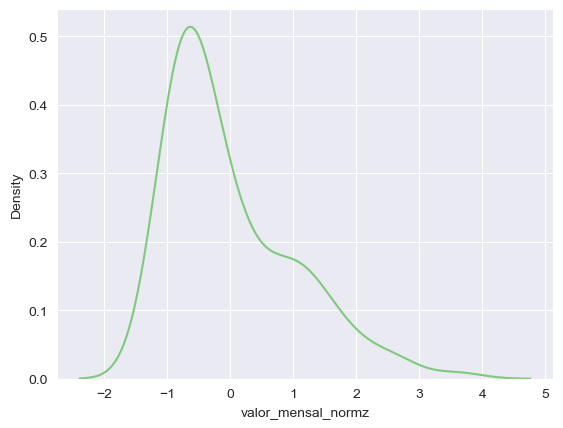

In [83]:
sns.kdeplot(df_receita_mes_ano_normz['valor_mensal_normz'])
plt.show()

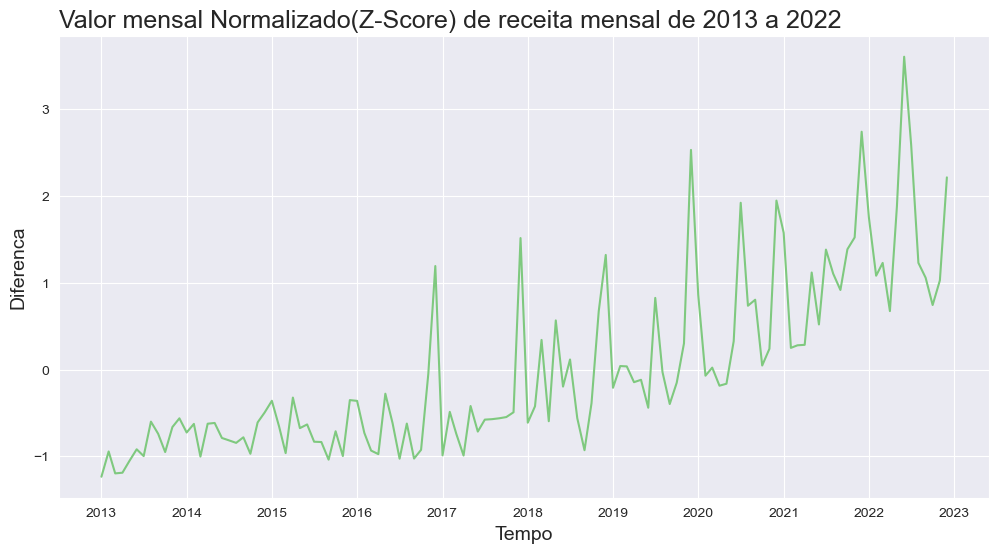

In [84]:
plotar('Valor mensal Normalizado(Z-Score) de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','valor_mensal_normz',df_receita_mes_ano_normz)

In [85]:
df_receita_mes_ano_normz['diferenca_receita_mensal_normz'] = df_receita_mes_ano_normz['valor_mensal_normz'].diff()
df_receita_mes_ano_normz['aceleracao_diferenca_receita_mensal_normz'] = df_receita_mes_ano_normz['diferenca_receita_mensal_normz'].diff()
df_receita_mes_ano_normz

mes_ano  valor_mensal  valor_mensal_normz  \
0   2013-01-01    5855243.48           -1.235152   
1   2013-02-01    6977997.85           -0.943995   
2   2013-03-01    6003101.60           -1.196809   
3   2013-04-01    6033704.83           -1.188873   
4   2013-05-01    6558550.11           -1.052768   
..         ...           ...                 ...   
115 2022-05-01   17872926.83            1.881321   
116 2022-04-01   13217971.69            0.674179   
117 2022-03-01   15360587.35            1.229811   
118 2022-02-01   14791870.57            1.082329   
119 2022-01-01   17381431.99            1.753864   

     diferenca_receita_mensal_normz  aceleracao_diferenca_receita_mensal_normz  
0                               NaN                                        NaN  
1                          0.291157                                        NaN  
2                         -0.252814                                  -0.543971  
3                          0.007936                                   0.260750  
4                          0.136105                                   0.128169  
..                              ...                                        ...  
115                       -1.725543                                  -2.740460  
116                       -1.207141                                   0.518402  
117                        0.555631                                   1.762773  
118                       -0.147482                                  -0.703113  
119                        0.671535                                   0.819017  

[120 rows x 5 columns]

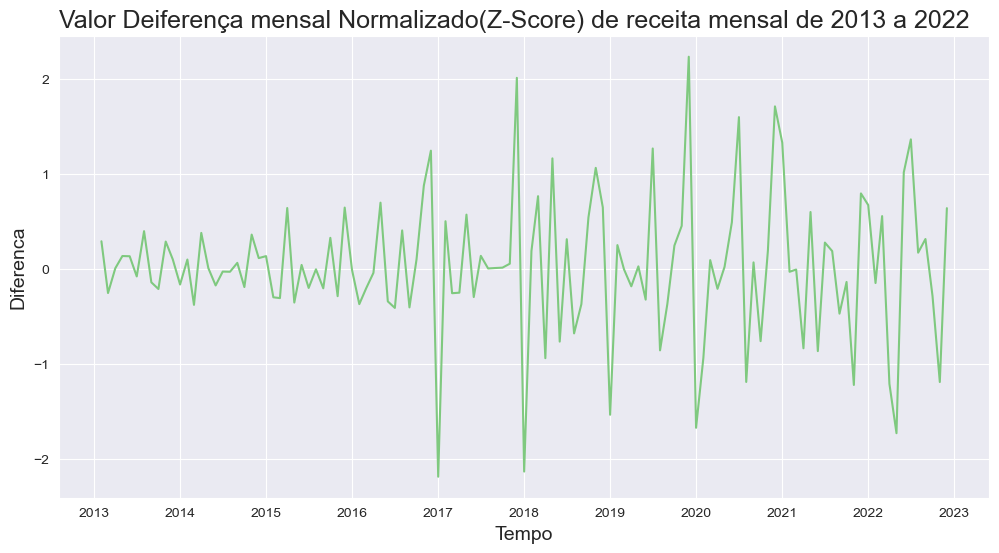

In [86]:
plotar('Valor Deiferença mensal Normalizado(Z-Score) de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','diferenca_receita_mensal_normz',df_receita_mes_ano_normz)

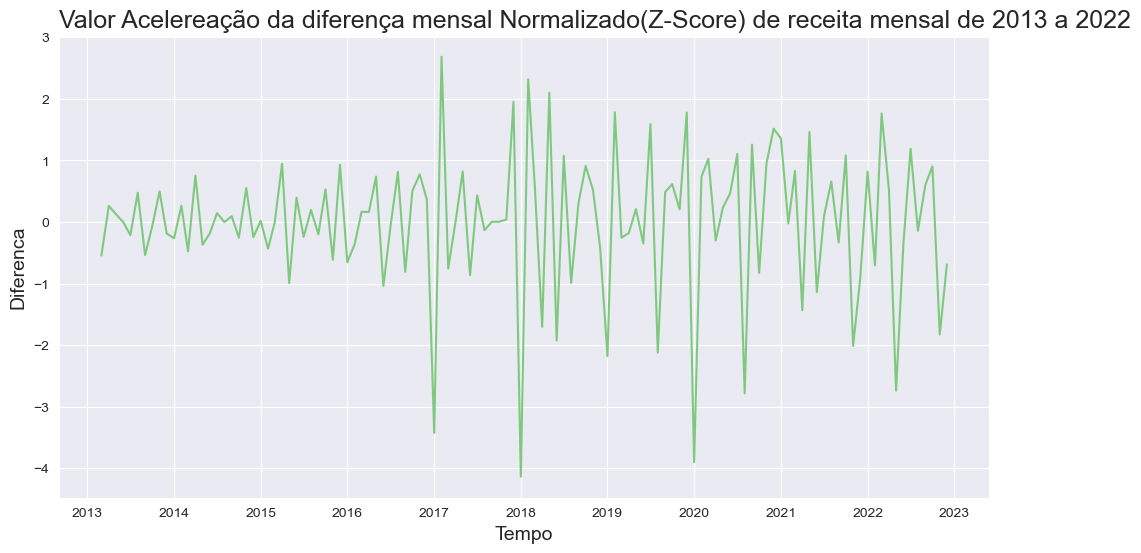

In [87]:
plotar('Valor Acelereação da diferença mensal Normalizado(Z-Score) de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','aceleracao_diferenca_receita_mensal_normz',df_receita_mes_ano_normz)

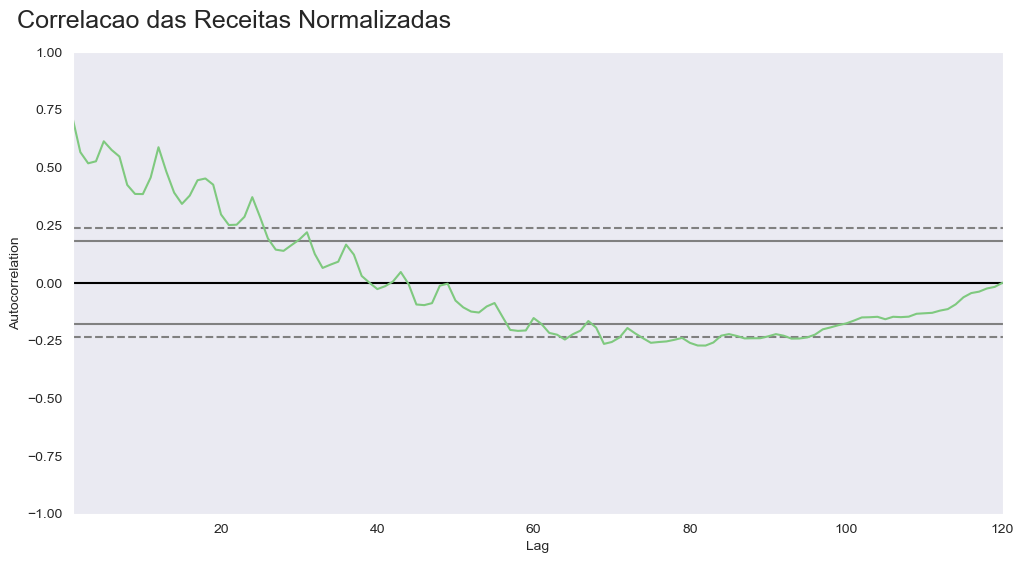

In [88]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao das Receitas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_normz['valor_mensal_normz'])
ax=ax

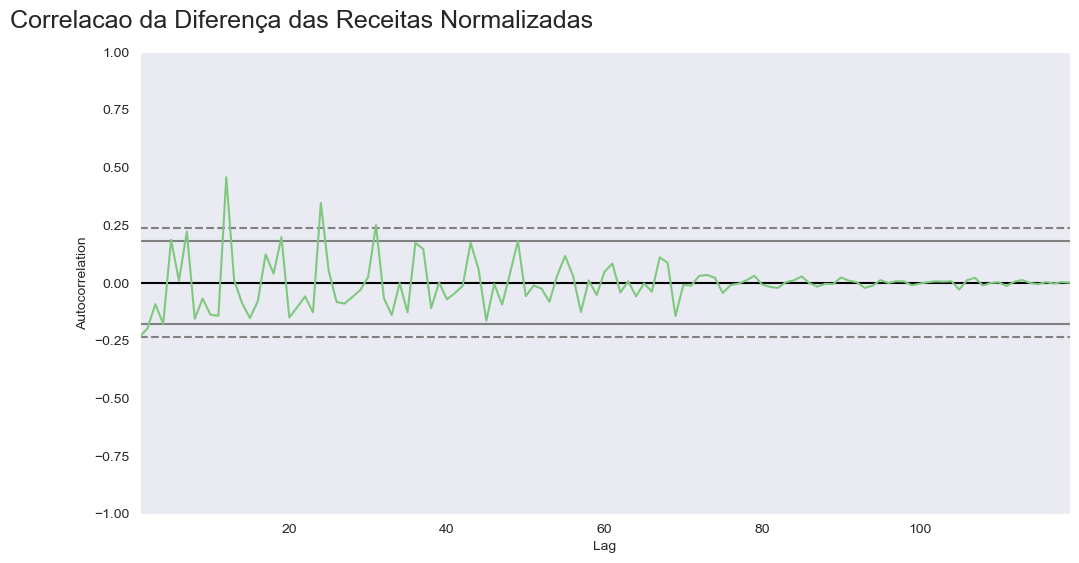

In [89]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao da Diferença das Receitas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_normz['diferenca_receita_mensal_normz'][1:])
ax=ax

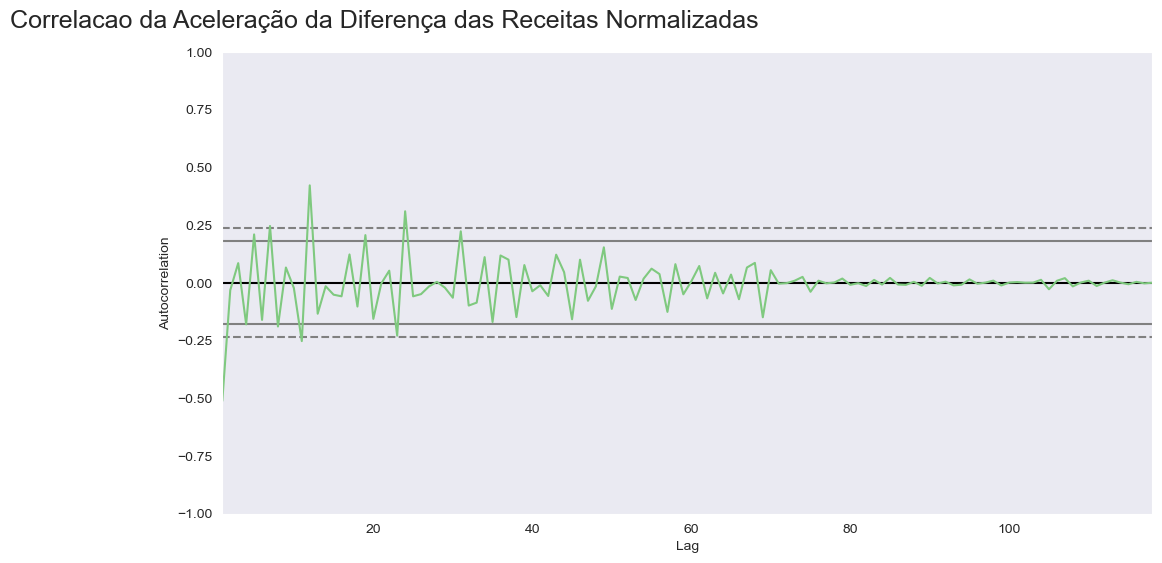

In [90]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao da Aceleração da Diferença das Receitas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_normz['aceleracao_diferenca_receita_mensal_normz'][2:])
ax=ax

### Normalização por Min-Max Scaling

In [91]:
from sklearn.preprocessing import MinMaxScaler

In [92]:
# Cria uma cópia do dataframe para normalização
df_receita_mes_ano_minmax = df_receita_mes_ano.copy()

# Seleciona apenas a coluna 'valor_mensal' para normalização
valores = df_receita_mes_ano_minmax['valor_mensal'].values.reshape(-1, 1)

# Normalização por min-max scaling
scaler = MinMaxScaler()
valores_norm = scaler.fit_transform(valores)

# Salva os valores normalizados no dataframe
df_receita_mes_ano_minmax['valor_mensal_minmax'] = valores_norm

df_receita_mes_ano_minmax

mes_ano  valor_mensal  valor_mensal_minmax
0   2013-01-01    5855243.48             0.000000
1   2013-02-01    6977997.85             0.060131
2   2013-03-01    6003101.60             0.007919
3   2013-04-01    6033704.83             0.009558
4   2013-05-01    6558550.11             0.037667
..         ...           ...                  ...
115 2022-05-01   17872926.83             0.643631
116 2022-04-01   13217971.69             0.394326
117 2022-03-01   15360587.35             0.509078
118 2022-02-01   14791870.57             0.478619
119 2022-01-01   17381431.99             0.617308

[120 rows x 3 columns]

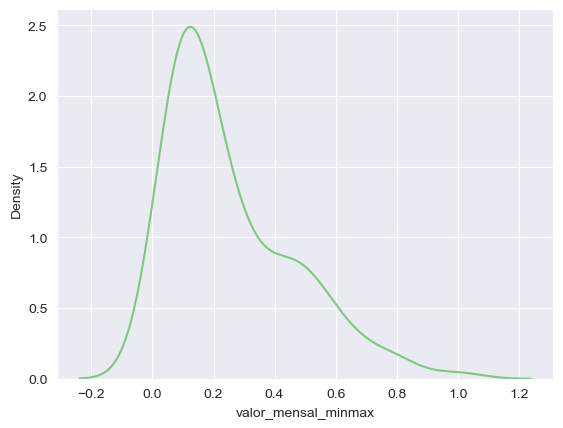

In [93]:
sns.kdeplot(df_receita_mes_ano_minmax['valor_mensal_minmax'])
plt.show()

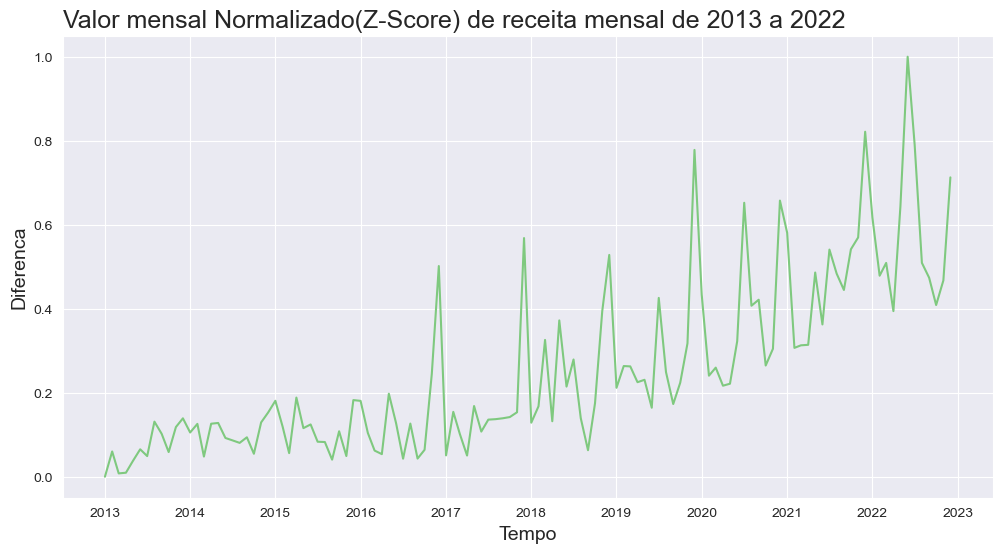

In [94]:
plotar('Valor mensal Normalizado(Z-Score) de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','valor_mensal_minmax',df_receita_mes_ano_minmax)

In [95]:
df_receita_mes_ano_minmax['diferenca_receita_mensal_minmax'] = df_receita_mes_ano_minmax['valor_mensal_minmax'].diff()
df_receita_mes_ano_minmax['aceleracao_diferenca_receita_mensal_minmax'] = df_receita_mes_ano_minmax['diferenca_receita_mensal_minmax'].diff()
df_receita_mes_ano_minmax

mes_ano  valor_mensal  valor_mensal_minmax  \
0   2013-01-01    5855243.48             0.000000   
1   2013-02-01    6977997.85             0.060131   
2   2013-03-01    6003101.60             0.007919   
3   2013-04-01    6033704.83             0.009558   
4   2013-05-01    6558550.11             0.037667   
..         ...           ...                  ...   
115 2022-05-01   17872926.83             0.643631   
116 2022-04-01   13217971.69             0.394326   
117 2022-03-01   15360587.35             0.509078   
118 2022-02-01   14791870.57             0.478619   
119 2022-01-01   17381431.99             0.617308   

     diferenca_receita_mensal_minmax  \
0                                NaN   
1                           0.060131   
2                          -0.052213   
3                           0.001639   
4                           0.028109   
..                               ...   
115                        -0.356369   
116                        -0.249306   
117                         0.114752   
118                        -0.030459   
119                         0.138689   

     aceleracao_diferenca_receita_mensal_minmax  
0                                           NaN  
1                                           NaN  
2                                     -0.112344  
3                                      0.053852  
4                                      0.026470  
..                                          ...  
115                                   -0.565975  
116                                    0.107063  
117                                    0.364058  
118                                   -0.145211  
119                                    0.169148  

[120 rows x 5 columns]

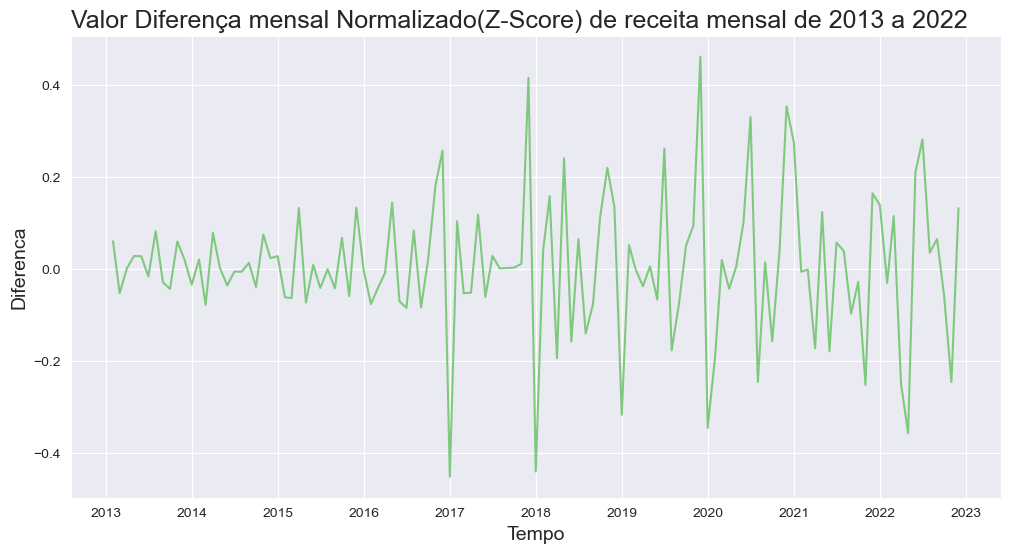

In [96]:
plotar('Valor Diferença mensal Normalizado(Z-Score) de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','diferenca_receita_mensal_minmax',df_receita_mes_ano_minmax)

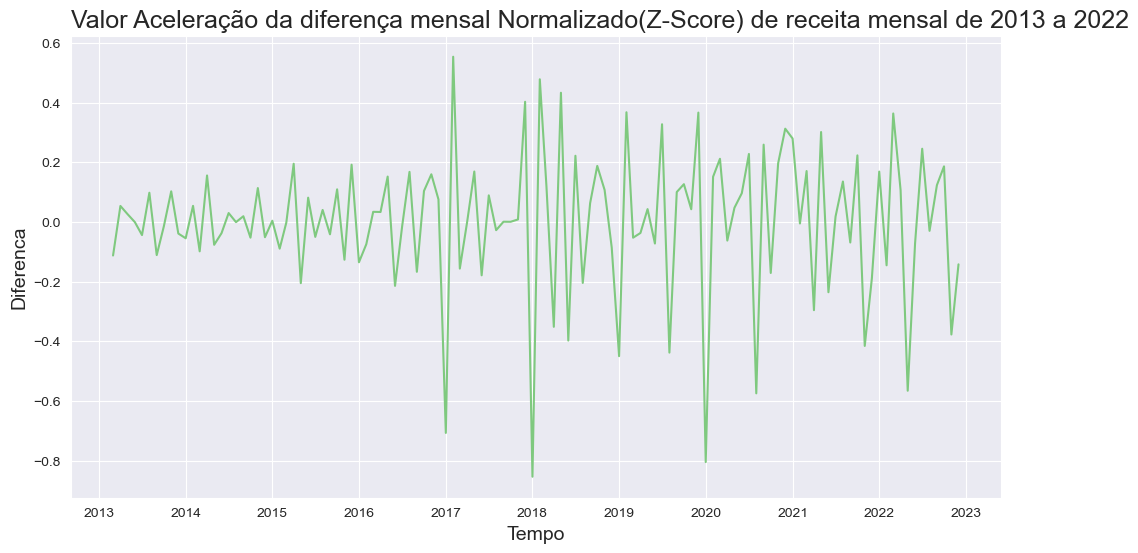

In [97]:
plotar('Valor Aceleração da diferença mensal Normalizado(Z-Score) de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','aceleracao_diferenca_receita_mensal_minmax',df_receita_mes_ano_minmax)

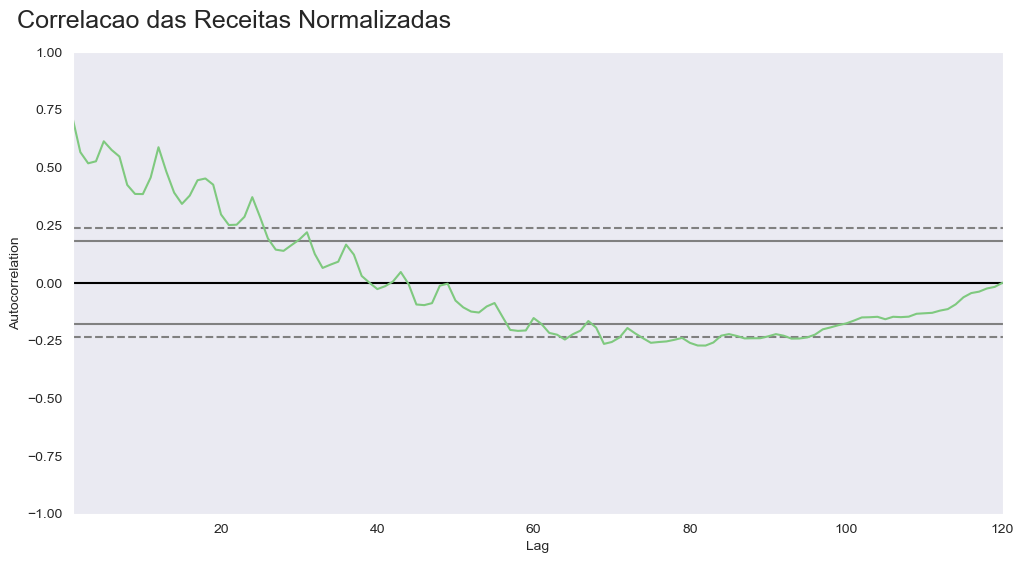

In [98]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao das Receitas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_minmax['valor_mensal_minmax'])
ax=ax

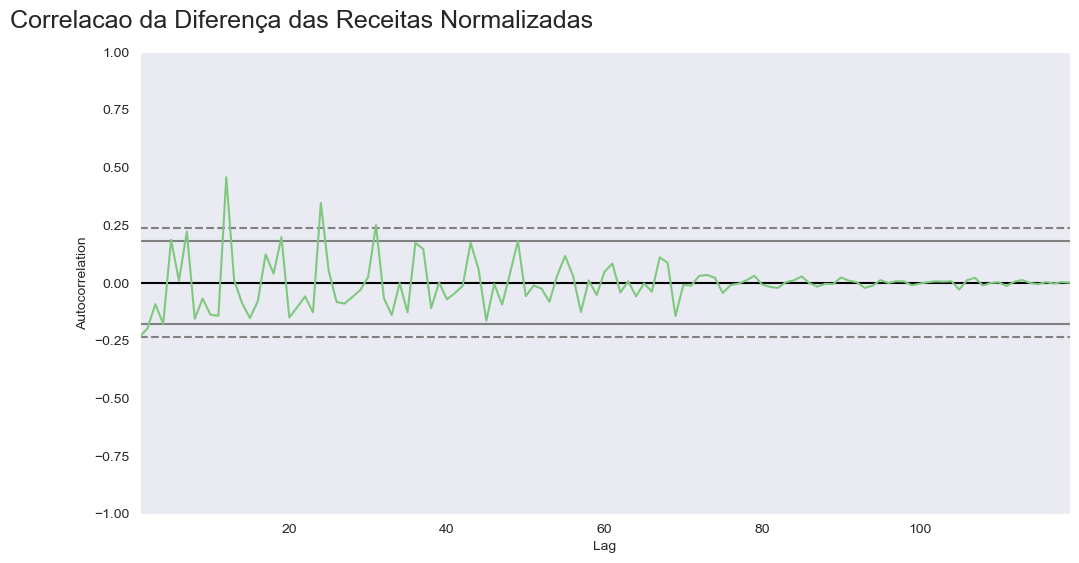

In [99]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao da Diferença das Receitas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_minmax['diferenca_receita_mensal_minmax'][1:])
ax=ax

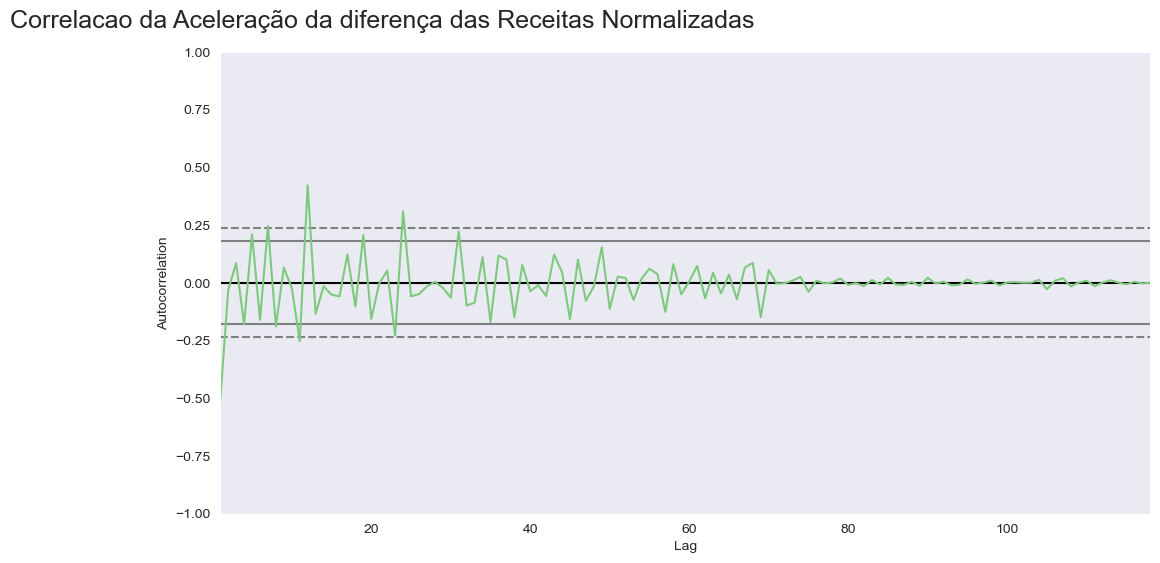

In [100]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao da Aceleração da diferença das Receitas Normalizadas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano_minmax['aceleracao_diferenca_receita_mensal_minmax'][2:])
ax=ax

## Análise regressiva

### Variável Dependente X Variáveis Explicativas

#### Pairplot

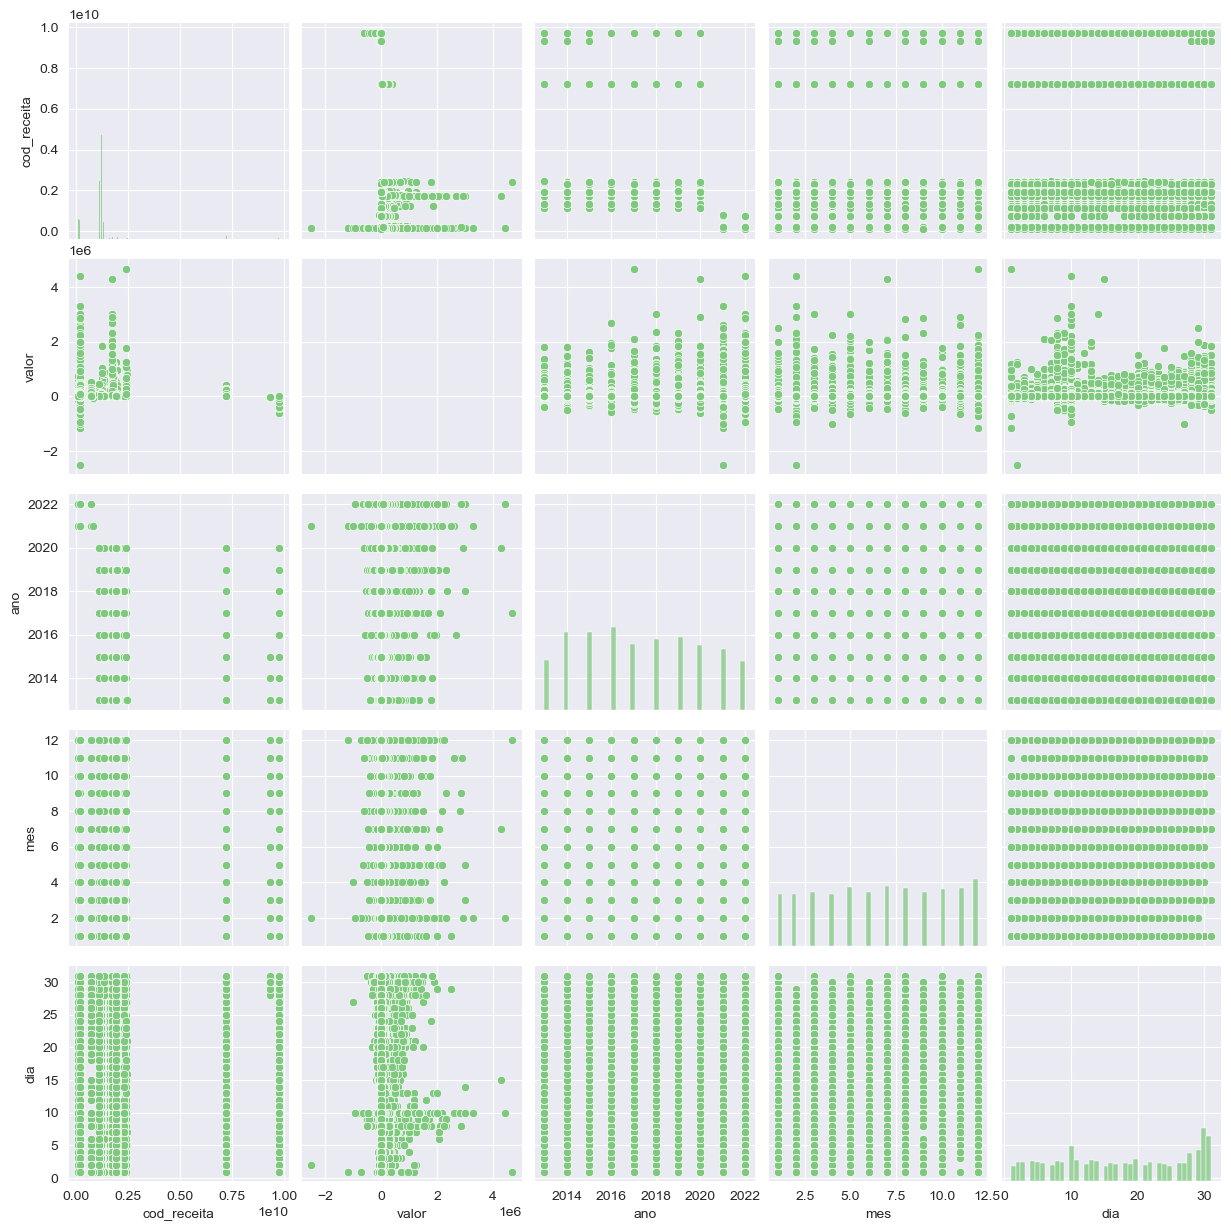

In [101]:
ax = sns.pairplot(df_receitas_copy)

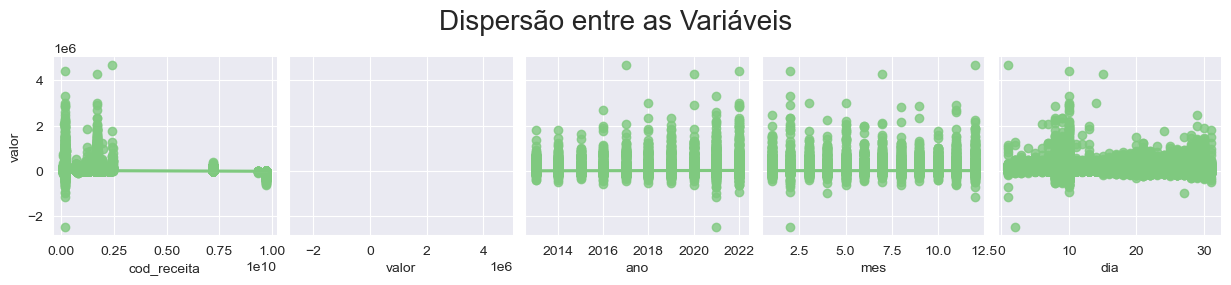

In [102]:
ax = sns.pairplot(df_receitas_copy, y_vars='valor', x_vars=['cod_receita','valor','ano','mes','dia'], kind = 'reg')
ax.fig.suptitle('Dispersão entre as Variáveis', fontsize = 20, y=1.1)
ax = ax

### Regressão Linear

#### Transformando variáveis categóricas em dummies

In [111]:
# # Transformando a variável categórica em variáveis dummy
# dummies = pd.get_dummies(df_receitas_copy['contribuinte_receita'])
# df_receitas_copy = pd.concat([df_receitas_copy, dummies], axis=1)

# # Removendo a coluna original 'codigo_receita'
# df_receitas_copy.drop('contribuinte_receita', axis=1, inplace=True)

# # Visualizando as primeiras linhas do DataFrame com as variáveis dummy
# df_receitas_copy

#### Definindo as variáveis independentes (y) e variável dependente(x)

In [186]:
df_amostra = df_receitas_copy.sample(frac=0.5)
df_amostra.reset_index(drop=True, inplace=True)
df_amostra

cod_receita  data_fato contribuinte_receita      valor   ano  mes  dia  \
0       1600990001 2013-06-05       886cd0eabf5a18  196150.10  2013    6    5   
1       2300990000 2016-07-15       afd5f2c52e49b3     381.00  2016    7   15   
2       1220990000 2016-02-16       331af28b760d58     189.33  2016    2   16   
3       1321001102 2019-03-29       2d027177369c9d      39.04  2019    3   29   
4       1931110001 2013-11-18       ef1dbf24acc7f0      87.53  2013   11   18   
...            ...        ...                  ...        ...   ...  ...  ...   
49370   1325019900 2018-02-28       2d027177369c9d       0.79  2018    2   28   
49371   1919150000 2018-04-02       23c9e86250ba86    3028.91  2018    4    2   
49372   1321001102 2020-12-31       2d027177369c9d       2.58  2020   12   31   
49373   1325000001 2013-01-31       886cd0eabf5a18     134.04  2013    1   31   
49374    132101011 2022-01-31       5c3f0f5bd2471d       6.78  2022    1   31   

       mes_ano  
0      06-2013  
1      07-2016  
2      02-2016  
3      03-2019  
4      11-2013  
...        ...  
49370  02-2018  
49371  04-2018  
49372  12-2020  
49373  01-2013  
49374  01-2022  

[49375 rows x 8 columns]

In [187]:
X = df_amostra[['cod_receita','ano','mes','dia']]
y = df_amostra['valor']

#### Dividindo o conjunto de dados em conjutos de treinamento e teste

#### Divisão dos dados em conjuntos de treinamento e teste

Neste trecho de código, estamos usando a função `train_test_split` da biblioteca Scikit-Learn para dividir o conjunto de dados em conjuntos de treinamento e teste. A função recebe como argumentos as variáveis independentes (X) e a variável dependente (y), bem como outros parâmetros opcionais.

Os parâmetros `test_size` e `random_state` são definidos na chamada da função e afetam a maneira como os dados são divididos em conjuntos de treinamento e teste. 

- `test_size`: define a proporção dos dados que serão utilizados para teste. Nesse caso, `test_size=0.2` significa que 20% dos dados serão usados para teste e 80% para treinamento.

- `random_state`: define uma semente aleatória para garantir que a divisão dos dados seja sempre a mesma, facilitando a reprodução dos resultados. Nesse caso, `random_state=42` é uma escolha comum, mas poderia ser qualquer outro valor.

A função `train_test_split` retorna quatro conjuntos de dados:

- `X_train`: conjunto de dados de treinamento para as variáveis independentes.
- `X_test`: conjunto de dados de teste para as variáveis independentes.
- `y_train`: conjunto de dados de treinamento para a variável dependente.
- `y_test`: conjunto de dados de teste para a variável dependente.

Esses conjuntos de dados são usados para treinar e testar o modelo de regressão. O conjunto de treinamento é usado para ajustar o modelo aos dados, enquanto o conjunto de teste é usado para avaliar o desempenho do modelo em dados novos e não vistos anteriormente.

É importante dividir os dados em conjuntos de treinamento e teste para evitar o overfitting, que ocorre quando o modelo é ajustado aos dados de treinamento de forma tão precisa que se torna incapaz de generalizar para novos dados. A divisão dos dados permite avaliar o desempenho do modelo em dados não utilizados para treinamento e ajustar os parâmetros do modelo para melhorar sua capacidade de generalização.


In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2811)

In [189]:
print(f'Df X_train: {X_train.shape}')
print(f'Df X_test: {X_test.shape}')
print(f'Df y_train: {y_train.shape}')
print(f'Df y_test: {y_test.shape}')

Df X_train: (34562, 4)
Df X_test: (14813, 4)
Df y_train: (34562,)
Df y_test: (14813,)


### Instanciando o modelo utilizado

#### Regressão Linear

In [190]:
# Transformando X_train e X_test em um array numpy bidimensional
# X_train = X_train.values.reshape((-1, 1))
# X_test = X_test.values.reshape((-1, 1))

In [191]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### Utilizando o modelo para previsões nos dados de teste

In [192]:
y_pred = model.predict(X_test)

#### Avaliando o desempenho com coef. determinação (R²)
O coeficiente de determinação (R²) é uma medida resumida que diz quanto a linha de regressão ajusta-se aos dados. É um valor entra 0 e 1.

In [193]:
print(f'R² = {r2_score(y_test, y_pred).round(4)}')

R² = 0.0044


In [194]:
print(f'R² = {model.score(X_test, y_test).round(4)}')

R² = 0.0044


#### Obtendo previsões pontuais

In [195]:
# dados de entrada
entrada=X_test[0:1]
entrada

cod_receita   ano  mes  dia
3377   1113050000  2018   10   25

In [196]:
# gerando previsão pontual
model.predict(entrada)[0]

13691.299706490245

In [197]:
# simulação simples
cod_receita = 1721010201
ano = 2013
mes = 12
dia = 15

entrada=[[cod_receita,ano,mes,dia]]

print(f'Simulação feita para a data: {dia}/{mes}/{ano}, com o código de receita: {cod_receita};\nR$ {model.predict(entrada)[0]:.2f}')

Simulação feita para a data: 15/12/2013, com o código de receita: 1721010201;
R$ 5088.34


#### Interpretação dos coeficientes estimados

##### Obtendo o intercepto do modelo
<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>O <b>intercepto</b> representa o efeito médio em $Y$ (Valor) tendo todas as variáveis explicativas excluídas do modelo. De forma mais simples, o <b>intercepto</b> representa o efeito médio em $Y$ (Valor) quando $X_2$ (Código da receita), $X_3$ (ano), $X_4$ (Mês) e $X_5$ (Dia) são iguais a zero.</p>

In [198]:
(model.intercept_).round(2)

-3108279.0

<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>Na regressão linear de dados de receitas mensais municipais, um intercepto negativo indica que mesmo quando todas as variáveis explicativas (como código da receita, ano, mês e dia) são iguais a zero, a previsão da receita ainda será um valor negativo. Isso pode indicar um problema na modelagem, uma vez que não faz sentido ter previsões negativas para receitas.</p>
<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>Caso o modelo seja considerado adequado, uma interpretação possível para um intercepto negativo é que pode haver uma variável importante que não foi incluída no modelo e que está afetando negativamente a previsão da receita. Por exemplo, pode haver uma variável externa ao modelo, como a crise econômica, que está afetando negativamente as receitas municipais.</p>
<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>De qualquer forma, é importante avaliar o modelo e as variáveis explicativas para entender a causa do intercepto negativo e tomar medidas para corrigir ou melhorar a modelagem, se necessário.</p>

##### Obtendo os coeficientes de regressão
<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>Os <b>coeficientes de regressão</b> $\beta_2$, $\beta_3$ e $\beta_4$ são conhecidos como <b>coeficientes parciais de regressão</b> ou <b>coeficientes parciais angulares</b>. Considerando o número de variáveis explicativas de nosso modelo, seu significado seria o seguinte: $\beta_2$ mede a variação no valor médio de $Y$ (Valor), por unidade de variação em $X_2$ (Código da receita), mantendo-se os valores de $X_3$ (Ano), $X_4$ (Mês) e $X_5$ (Dia) constantes. Em outras palavras, ele nos dá o efeito "direto" ou "líquido" de uma unidade de variação em $X_2$ sobre o valor médio de $Y$, excluídos os efeitos que $X_3$, $X_4$ e $X_5$ possam ter sobre a média de $Y$. De modo análogo podemos interpretar os demais coeficientes de regressão.</p>

In [199]:
(model.coef_).round(2)

array([  -0.  , 1549.81, -111.6 ,  -75.48])

##### Df para armazenar os coeficientes do modelo

In [200]:
# confirmando a ordem das variáveis explicativas no DF
X.columns

Index(['cod_receita', 'ano', 'mes', 'dia'], dtype='object')

In [201]:
# criando uma lista com os nomes das variáveis do modelo
index = ['Intercepto', 'Código Receita', 'Ano', 'Mês', 'Dia']

In [202]:
pd.DataFrame(data=np.append((model.intercept_).round(2),(model.coef_).round(2)), index=index, columns=['Parâmetros'])

Parâmetros
Intercepto     -3108279.00
Código Receita       -0.00
Ano                1549.81
Mês                -111.60
Dia                 -75.48

##### Interpretação dos Coeficientes Estimados

<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>
<b>Intercepto</b> → Excluindo o efeito das variáveis explicativas ($X_2=X_3=X_4=X_5=0$) o efeito médio no Valor da Receita seria de <b>R$ -307.0367,79</b>.
</p>

<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>
<b>Código Receita</b> → Mantendo-se os valores de $X_3$ (Ano), $X_4$ (Mês) e $X_5$ (Dia) constantes, a variação no tipo de receita que estaria entrando no Orçamento Público seria de <b>R$ -0,00</b>. O que indica que o tipo de receita não interfere na previsão das receitas futuras.
</p>

<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>
<b>Ano</b> → Mantendo-se os valores de $X_2$ (Código Receita), $X_4$ (Mês) e $X_5$ (Dia) constantes, o acréscimo de 1(um) ano gera uma variação média no Valor da receita de <b>R$ 1530,52</b>.
</p>

<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>
<b>Mês</b> → Mantendo-se os valores de $X_2$ (Código Receita), $X_3$ (Ano) e $X_5$ (Dia) constantes, o acréscimo de 1(um) mês gera uma variação média no Valor da receita de <b>R$ 138,35</b>.
</p>

<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>
<b>Dia</b> → Mantendo-se os valores de $X_2$ (Código Receita), $X_3$ (Ano) e $X_4$ (Mês) constantes, o acréscimo de 1(um) dia gera uma variação média no Valor da receita de <b>R$ -102,46</b>.
</p>

### Análises gráficas das previsões do modelo

In [203]:
# gerando as previsões do modelo para os dados de treino
y_previsto_train = model.predict(X_train)

##### Métricas da regressão
<hr>

<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>fonte: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics</p>

<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>Algumas estatísticas obtidas do modelo de regressão são muito úteis como critério de comparação entre modelos estimados e de seleção do melhor modelo, as principais métricas de regressão que o scikit-learn disponibiliza para modelos lineares são as seguintes:</p>

<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>Erro Quadrático Médio: Média dos quadrados dos erros. Ajustes melhores apresentam $EQM$ mais baixo.</p>

<p style='font-size: 15px; line-height: 2; margin: 10px 50px; text-align: justify;'>Raíz do Erro Quadrático Médio: Raíz quadrada da média dos quadrados dos erros. Ajustes melhores apresentam $\sqrt{EQM}$ mais baixo.</p>

In [204]:
# obtendo métricas para o modelo
EQM = metrics.mean_squared_error(y_test,y_pred).round(4)
REQM = np.sqrt(EQM).round(4)
R2 = metrics.r2_score(y_test, y_pred).round(4)

pd.DataFrame([EQM,REQM,R2],['EQM','REQM','R²'], columns=['Métricas'])

Métricas
EQM   7.824005e+09
REQM  8.845341e+04
R²    4.400000e-03

#### Gráfico de dispersão entre valor estimado e real

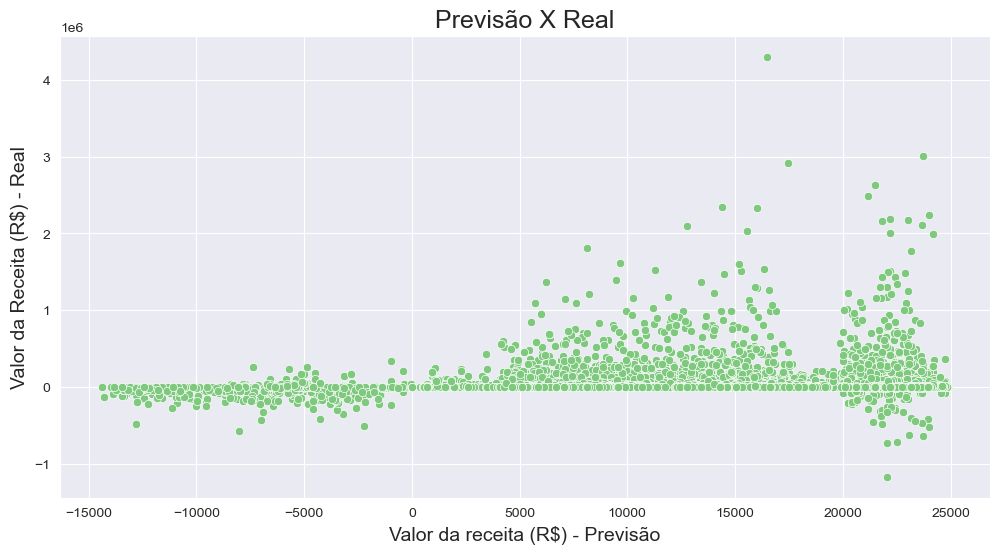

In [205]:
ax = sns.scatterplot(x=y_previsto_train, y= y_train)
ax.figure.set_size_inches(12,6)
ax.set_title('Previsão X Real', fontsize=18)
ax.set_xlabel('Valor da receita (R$) - Previsão', fontsize=14)
ax.set_ylabel('Valor da Receita (R$) - Real', fontsize=14)
ax=ax

#### Obtendo os resíduos

In [206]:
residuo = y_train - y_previsto_train
residuo

22993   -20761.464107
38906   -18487.466077
39751   -17356.762876
48140   -11203.460802
19655   -14217.782167
             ...     
23255   -19595.610621
10581    -8054.706168
23534   -19611.798563
41407    -7048.587659
34776   -17947.346329
Name: valor, Length: 34562, dtype: float64

##### Gráfico de dispersão entre valor estimado e resíduos
<p>Método informal de verificação da hipótese de variância constante deos resíduos (homocedasticidade).</p>

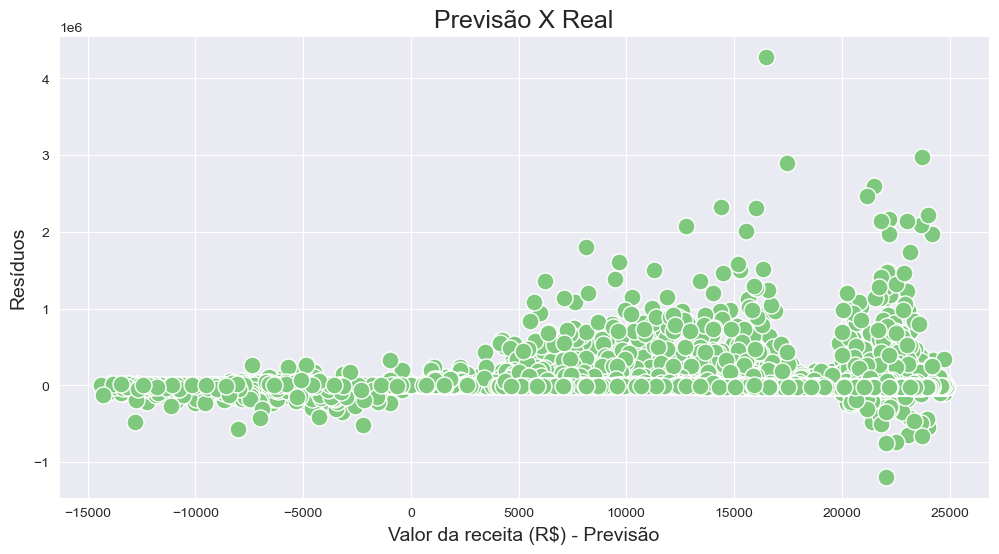

In [207]:
ax = sns.scatterplot(x=y_previsto_train, y= residuo, s=150)
ax.figure.set_size_inches(12,6)
ax.set_title('Previsão X Real', fontsize=18)
ax.set_xlabel('Valor da receita (R$) - Previsão', fontsize=14)
ax.set_ylabel('Resíduos', fontsize=14)
ax=ax

##### Utilizando resíduos ao quadrado

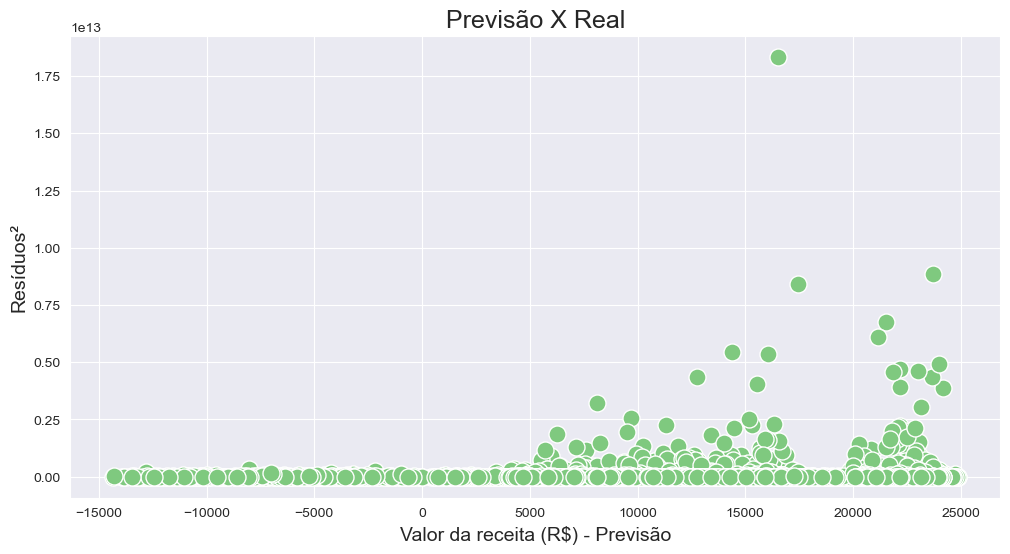

In [208]:
ax = sns.scatterplot(x=y_previsto_train, y= residuo**2, s=150)
ax.figure.set_size_inches(12,6)
ax.set_title('Previsão X Real', fontsize=18)
ax.set_xlabel('Valor da receita (R$) - Previsão', fontsize=14)
ax.set_ylabel('Resíduos²', fontsize=14)
ax=ax

##### Plotando a distribuição de frequência dos resíduos

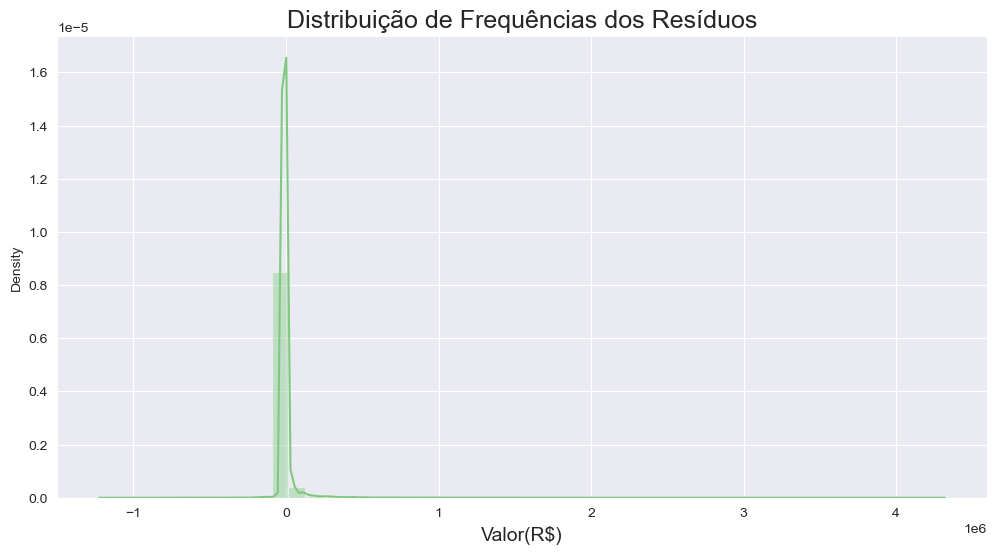

In [209]:
ax = sns.distplot(residuo)
ax.figure.set_size_inches(12,6)
ax.set_title('Distribuição de Frequências dos Resíduos', fontsize=18)
ax.set_xlabel('Valor(R$)', fontsize=14)
ax=ax